<center><b><p><div style="margin: auto; padding: 15px; color:#FFFFFF; font-size: 20px">TEAM 07</b></div>
<br>
<center><div style="font-size: 18px"><center><i>Cédric Sollie  | Fernanda Cortés
<center><div style="font-size: 18px"><center><i>Kei Iwawaki | Trinh Bao Quyen Nguyen | Gabriel Herrera

        
        
        
<hr style="width:100%; background-color: #f0ffff ; height:1px"></hr>

<div style="font-size: 18px"><center><b>Hult International Business School</div>
<div style="font-size: 18px"><center><b>Business Challenge #3 </div>
<div style="font-size: 18px"><center><b>Luis Escamilla</div>
<div style="font-size: 18px"><center><b>May 5th, 2023</div>
<hr style="width:100%; background-color: #f0ffff ; height:1px"></hr>

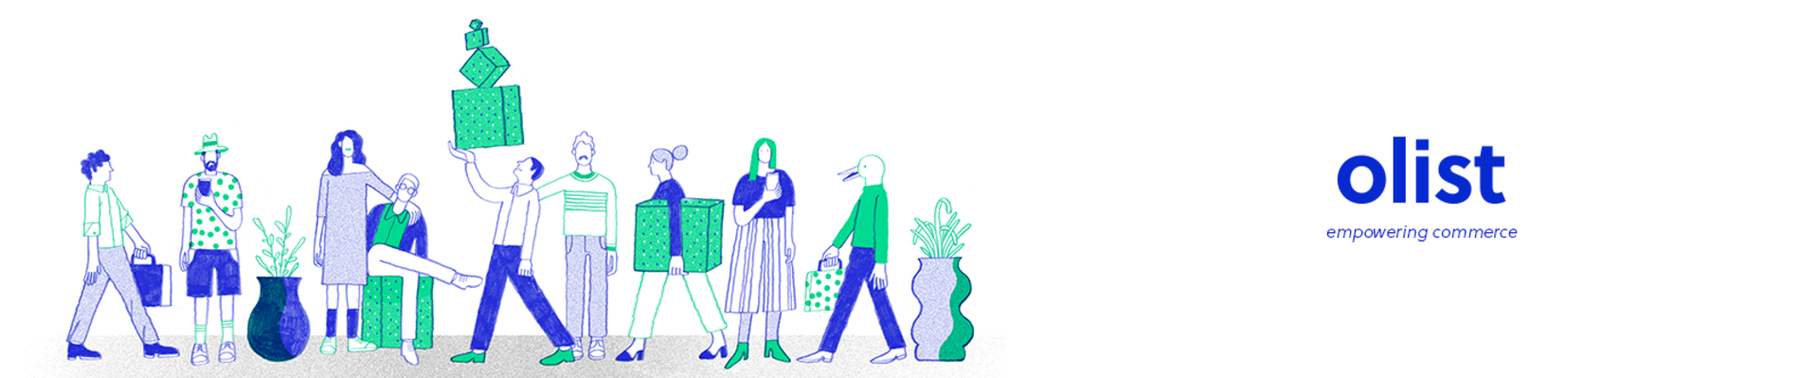

## Importing Libraries

In [151]:
#LIBARIES NEEDED
#%pip install mysql-connector-python
#%pip install unidecode
#%matplotlib inline
#%pip install vaderSentiment
#%pip install -U textblob
#%pip install mtranslate

import numpy as np
import mysqlx
import mysql.connector
import pandas as pd
import locale
import matplotlib.pyplot as plt
import seaborn as sns
import vaderSentiment
import nltk
import string
import requests
import json
import urllib.parse
import mtranslate


from mtranslate import translate
from collections import Counter
from unidecode import unidecode
from datetime import datetime
from datetime import timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

## Connecting to SQL

In [2]:
# Connecting to SQL using my credentials
dbcon = mysql.connector.connect(
host="68.66.233.182",
port=3306,
user="gherrera1",
password="24961531")

try:
# Reading SQL query
    SQL_leads = pd.read_sql_query(
    '''SELECT * FROM H_Olist.leads''', dbcon)
    SQL_merchants = pd.read_sql_query(
    '''SELECT * FROM H_Olist.merchants''', dbcon)
    SQL_merchants_W = pd.read_sql_query(
    '''SELECT * FROM H_Olist.merchant_saas_won''', dbcon)
    SQL_order = pd.read_sql_query(
    '''SELECT * FROM H_Olist.order_line_items''', dbcon)
    SQL_reviews = pd.read_sql_query(
    '''SELECT * FROM H_Olist.reviews''', dbcon)
    SQL_reviews_bis = pd.read_sql_query(
    '''SELECT * FROM H_Olist.reviews_bis''', dbcon)
    

# Assigning 'df' to dataset and converting it to a DataFrame
    leads = pd.DataFrame(SQL_leads)
    merchants = pd.DataFrame(SQL_merchants)
    merchants_W = pd.DataFrame(SQL_merchants_W)
    order = pd.DataFrame(SQL_order)
    reviews = pd.DataFrame(SQL_reviews)
    reviews_bis = pd.DataFrame(SQL_reviews_bis)
    
except:
    print("Error: unable to convert the data")

# Closing SQL connection
dbcon.close()

/Users/fernandacg/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/fernandacg/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/fernandacg/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/fernandacg/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQL

## Changing data types and formats

### Leads Table

In [3]:
leads['registered_on_landing_page_date'] = leads['registered_on_landing_page_date'].astype(str)
leads['registered_on_landing_page_date'] = leads['registered_on_landing_page_date'].str.replace(',', '')
leads['registered_on_landing_page_date'] = leads['registered_on_landing_page_date'].str.replace("\'", '')
leads

,lead_id,registered_on_landing_page_date,landing_page_id,lead_type,origin
0,0002ac0d783338cfeab0b2bdbd872cda,novembro 14 20,b76ef37428e6799c421989521c0e5077,,unknown
1,000dd3543ac84d906eae52e7c779bb2a,abril 5 21,b48ec5f3b04e9068441002a19df93c6c,industry,organic_search
2,001d3439223b7bb23ed89b9c8890d096,abril 14 21,35c9b150ab36fe584c1f24fd458c453a,,paid_search
3,00275937100699204a3d5ae3caf7190d,janeiro 11 21,a7982125ff7aa3b2054c6e44f9d28522,,organic_search
4,003d859bbd84a526b9e06340ce7d185f,abril 2 21,22c29808c4f815213303f8933030604c,,direct_traffic
...,...,...,...,...,...
7995,ffe640179b554e295c167a2f6be528e0,outubro 9 20,a0fbc0263cb98bdb0d72b9f9f283a172,industry,unknown
7996,ffec39090fa0c85692730fdbd647e34d,abril 17 21,515742ea988a44a8ca0ddc44ff92735f,,email
7997,ffec991bf0f35f7e7688cf0d39c9f9f4,novembro 23 20,b76ef37428e6799c421989521c0e5077,,unknown
7998,fff8db9478d2fd72df65a67ee6b62f67,janeiro 20 21,c0fa54bbdd331f215aa84b4dd86d7255,online_medium,direct_traffic


In [4]:
# Define a function to convert the date format in the leads table
def convert_date(date_str):
    # set the locale to Portuguese
    locale.setlocale(locale.LC_TIME, 'pt_BR')
    # replace non-standard apostrophe with standard single quote
    date_str = date_str.replace(",", "")
    date_str = date_str.replace("\'", '')
    # replace non-ASCII characters in march
    date_str = unidecode(date_str)
    # replace maro to março for the function to detect that month too
    date_str = date_str.replace("maro", 'março')
    # parse the date string into a datetime object
    date_obj = datetime.strptime(date_str, "%B %d %y")
    # convert the datetime object back to a string in the desired format
    return date_obj.strftime("%Y-%m-%d")

# apply the function to the 'date' column
leads['registered_on_landing_page_date'] = leads['registered_on_landing_page_date'].apply(convert_date)

# change locale back to english
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

leads

,lead_id,registered_on_landing_page_date,landing_page_id,lead_type,origin
0,0002ac0d783338cfeab0b2bdbd872cda,2020-11-14,b76ef37428e6799c421989521c0e5077,,unknown
1,000dd3543ac84d906eae52e7c779bb2a,2021-04-05,b48ec5f3b04e9068441002a19df93c6c,industry,organic_search
2,001d3439223b7bb23ed89b9c8890d096,2021-04-14,35c9b150ab36fe584c1f24fd458c453a,,paid_search
3,00275937100699204a3d5ae3caf7190d,2021-01-11,a7982125ff7aa3b2054c6e44f9d28522,,organic_search
4,003d859bbd84a526b9e06340ce7d185f,2021-04-02,22c29808c4f815213303f8933030604c,,direct_traffic
...,...,...,...,...,...
7995,ffe640179b554e295c167a2f6be528e0,2020-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,industry,unknown
7996,ffec39090fa0c85692730fdbd647e34d,2021-04-17,515742ea988a44a8ca0ddc44ff92735f,,email
7997,ffec991bf0f35f7e7688cf0d39c9f9f4,2020-11-23,b76ef37428e6799c421989521c0e5077,,unknown
7998,fff8db9478d2fd72df65a67ee6b62f67,2021-01-20,c0fa54bbdd331f215aa84b4dd86d7255,online_medium,direct_traffic


### Revenue Table

In [5]:
merchants['declared_monthly_revenue'].astype(float).sum()

61784006.0

### Order Line Items Table

In [6]:
# convert price column to float type
order['price'] = order['price'].astype(float)

## Dropping Useless Columns

### Dropping Columns with high percentage of NaN's

#### Merchants Table

In [7]:
merchants.head()

,merchant_id,lead_id,sdr_id,sr_id,business_segment,lead_behavior,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,00065220becb8785e2cf78355eb9bf68,00dc5000951c268cc8655294daf67b1b,9d12ef1a7eca3ec58c545c678af7869c,de63de0d10a6012430098db33c679b0b,handcrafted,Stability / Green,False,False,20-50,reseller,,0.0
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,4b339f9567d060bcea4f5136b9f5949e,6565aa9ce3178a5caf6171827af3a9ba,construction_tools_house_garden,Stability / Green,,,,reseller,,0.0
2,013d100f608a64ec8275c038aedeb064,f7066703eb3987f21f0d102ea8caaeb5,a8387c01a09e99ce014107505b92388c,495d4e95a8cf8bbf8b432b612a2aa328,food_supplement,,,,,reseller,,0.0
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,09285259593c61296eef10c734121d5b,85fc447d336637ba1df43e793199fbc8,household_utilities,Stability / Green,,,,reseller,,0.0
4,0255dc67cb6bad298606136951ab1877,4388a23da67b154b780b78dd7ea4636e,4b339f9567d060bcea4f5136b9f5949e,6565aa9ce3178a5caf6171827af3a9ba,computers,Conformity / Blue,,,,reseller,,0.0


In [8]:
# Replace empty values with NaN
merchants.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(merchants.isna().sum())

merchant_id                        0
lead_id                            0
sdr_id                             0
sr_id                              0
business_segment                   1
lead_behavior                    177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                     10
declared_product_catalog_size    773
declared_monthly_revenue           0
dtype: int64


In [9]:
print(merchants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   merchant_id                    842 non-null    object
 1   lead_id                        842 non-null    object
 2   sdr_id                         842 non-null    object
 3   sr_id                          842 non-null    object
 4   business_segment               841 non-null    object
 5   lead_behavior                  665 non-null    object
 6   has_company                    63 non-null     object
 7   has_gtin                       64 non-null     object
 8   average_stock                  66 non-null     object
 9   business_type                  832 non-null    object
 10  declared_product_catalog_size  69 non-null     object
 11  declared_monthly_revenue       842 non-null    object
dtypes: object(12)
memory usage: 79.1+ KB
None


In [10]:
# Computing percentage of null values in each column
null_perc1 = merchants.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc1)

merchant_id                       0.000000
lead_id                           0.000000
sdr_id                            0.000000
sr_id                             0.000000
business_segment                  0.118765
lead_behavior                    21.021378
has_company                      92.517815
has_gtin                         92.399050
average_stock                    92.161520
business_type                     1.187648
declared_product_catalog_size    91.805226
declared_monthly_revenue          0.000000
dtype: float64


In [11]:
# Dropping columns with high percentage of null values
merchants = merchants.drop(merchants.columns[[-2,-4,-5,-6]], axis = 1)
merchants

,merchant_id,lead_id,sdr_id,sr_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,00065220becb8785e2cf78355eb9bf68,00dc5000951c268cc8655294daf67b1b,9d12ef1a7eca3ec58c545c678af7869c,de63de0d10a6012430098db33c679b0b,handcrafted,Stability / Green,reseller,0.0
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,4b339f9567d060bcea4f5136b9f5949e,6565aa9ce3178a5caf6171827af3a9ba,construction_tools_house_garden,Stability / Green,reseller,0.0
2,013d100f608a64ec8275c038aedeb064,f7066703eb3987f21f0d102ea8caaeb5,a8387c01a09e99ce014107505b92388c,495d4e95a8cf8bbf8b432b612a2aa328,food_supplement,NaN,reseller,0.0
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,09285259593c61296eef10c734121d5b,85fc447d336637ba1df43e793199fbc8,household_utilities,Stability / Green,reseller,0.0
4,0255dc67cb6bad298606136951ab1877,4388a23da67b154b780b78dd7ea4636e,4b339f9567d060bcea4f5136b9f5949e,6565aa9ce3178a5caf6171827af3a9ba,computers,Conformity / Blue,reseller,0.0
...,...,...,...,...,...,...,...,...
837,fe53fc6949a462475c07fcb57ead57ce,803fce03a8d1123afbbdbbbad0c4377d,9e4d1098a3b0f5da39b0bc48f9876645,9ae085775a198122c5586fa830ff7f2b,home_decor,Dominant / Red,manufacturer,0.0
838,fe87f472055fbcf1d7e691c00b1560dc,b8bb2a1d59f4ecae0646fc039b75391e,56bf83c4bb35763a51c2baab501b4c67,495d4e95a8cf8bbf8b432b612a2aa328,home_decor,NaN,reseller,0.0
839,ffa6adafb71b807dc13159e26431354c,a0a7ffa593070c447c15f66e0aab9785,9e4d1098a3b0f5da39b0bc48f9876645,6565aa9ce3178a5caf6171827af3a9ba,car_accessories,Influence / Yellow,manufacturer,0.0
840,ffad1e7127fb622cb64a900751590acd,ab65e1a4d850fa15d38469a1ad02ce90,56bf83c4bb35763a51c2baab501b4c67,9ae085775a198122c5586fa830ff7f2b,home_decor,NaN,manufacturer,0.0


In [12]:
# Computing percentage of null values in each column
null_perc1 = merchants.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc1)

merchant_id                  0.000000
lead_id                      0.000000
sdr_id                       0.000000
sr_id                        0.000000
business_segment             0.118765
lead_behavior               21.021378
business_type                1.187648
declared_monthly_revenue     0.000000
dtype: float64


#### Leads Table

In [13]:
leads.head()

,lead_id,registered_on_landing_page_date,landing_page_id,lead_type,origin
0,0002ac0d783338cfeab0b2bdbd872cda,2020-11-14,b76ef37428e6799c421989521c0e5077,,unknown
1,000dd3543ac84d906eae52e7c779bb2a,2021-04-05,b48ec5f3b04e9068441002a19df93c6c,industry,organic_search
2,001d3439223b7bb23ed89b9c8890d096,2021-04-14,35c9b150ab36fe584c1f24fd458c453a,,paid_search
3,00275937100699204a3d5ae3caf7190d,2021-01-11,a7982125ff7aa3b2054c6e44f9d28522,,organic_search
4,003d859bbd84a526b9e06340ce7d185f,2021-04-02,22c29808c4f815213303f8933030604c,,direct_traffic


In [14]:
# Replace empty values with NaN
leads.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(leads.isna().sum())

lead_id                               0
registered_on_landing_page_date       0
landing_page_id                       0
lead_type                          7164
origin                               60
dtype: int64


In [15]:
print(leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   lead_id                          8000 non-null   object
 1   registered_on_landing_page_date  8000 non-null   object
 2   landing_page_id                  8000 non-null   object
 3   lead_type                        836 non-null    object
 4   origin                           7940 non-null   object
dtypes: object(5)
memory usage: 312.6+ KB
None


In [16]:
# Computing percentage of null values in each column
null_perc2 = leads.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc2)

lead_id                             0.00
registered_on_landing_page_date     0.00
landing_page_id                     0.00
lead_type                          89.55
origin                              0.75
dtype: float64


In [17]:
# Dropping columns with high percentage of null values
leads = leads.drop(leads.columns[-2], axis = 1)
leads

,lead_id,registered_on_landing_page_date,landing_page_id,origin
0,0002ac0d783338cfeab0b2bdbd872cda,2020-11-14,b76ef37428e6799c421989521c0e5077,unknown
1,000dd3543ac84d906eae52e7c779bb2a,2021-04-05,b48ec5f3b04e9068441002a19df93c6c,organic_search
2,001d3439223b7bb23ed89b9c8890d096,2021-04-14,35c9b150ab36fe584c1f24fd458c453a,paid_search
3,00275937100699204a3d5ae3caf7190d,2021-01-11,a7982125ff7aa3b2054c6e44f9d28522,organic_search
4,003d859bbd84a526b9e06340ce7d185f,2021-04-02,22c29808c4f815213303f8933030604c,direct_traffic
...,...,...,...,...
7995,ffe640179b554e295c167a2f6be528e0,2020-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown
7996,ffec39090fa0c85692730fdbd647e34d,2021-04-17,515742ea988a44a8ca0ddc44ff92735f,email
7997,ffec991bf0f35f7e7688cf0d39c9f9f4,2020-11-23,b76ef37428e6799c421989521c0e5077,unknown
7998,fff8db9478d2fd72df65a67ee6b62f67,2021-01-20,c0fa54bbdd331f215aa84b4dd86d7255,direct_traffic


In [18]:
# Computing percentage of null values in each column
null_perc2 = leads.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc2)

lead_id                            0.00
registered_on_landing_page_date    0.00
landing_page_id                    0.00
origin                             0.75
dtype: float64


#### Merchants W Table

In [19]:
merchants_W.head()

,merchant_id,won_date_ie_date_of_first_saas_payment
0,00065220becb8785e2cf78355eb9bf68,2021-07-10
1,01266d4c46afa519678d16a8b683d325,2021-05-18
2,013d100f608a64ec8275c038aedeb064,2021-04-06
3,01fd077212124329bac32490e8ef80d9,2021-03-28
4,0255dc67cb6bad298606136951ab1877,2021-03-06


In [20]:
# Replace empty values with NaN
merchants_W.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(merchants_W.isna().sum())

merchant_id                               0
won_date_ie_date_of_first_saas_payment    0
dtype: int64


In [21]:
print(merchants_W.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   merchant_id                             842 non-null    object
 1   won_date_ie_date_of_first_saas_payment  842 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB
None


#### Order Line Items Table

In [22]:
order.head()

,order_id,order_line_item,product_id,seller_id,order_date_time,price,freight_cost
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2020-05-03 11:05:13,239.90,19.93
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2021-01-18 14:48:30,199.00,17.87
2,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2021-08-15 10:10:18,12.99,12.79
3,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2020-02-14 13:57:51,199.90,18.14
4,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2020-05-23 03:55:27,21.90,12.69


In [23]:
# Replace empty values with NaN
order.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(order.isna().sum())

order_id            0
order_line_item     0
product_id          0
seller_id           0
order_date_time    21
price               0
freight_cost        0
dtype: int64


In [24]:
print(order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         112650 non-null  object 
 1   order_line_item  112650 non-null  object 
 2   product_id       112650 non-null  object 
 3   seller_id        112650 non-null  object 
 4   order_date_time  112629 non-null  object 
 5   price            112650 non-null  float64
 6   freight_cost     112650 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.0+ MB
None


In [25]:
# Computing percentage of null values in each column
null_perc4 = order.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc4)

order_id           0.000000
order_line_item    0.000000
product_id         0.000000
seller_id          0.000000
order_date_time    0.018642
price              0.000000
freight_cost       0.000000
dtype: float64


In [26]:
reviews.head()

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,"﻿""7bc2406110b926393aa56f80a40eba40""",73fc7af87114b39712e6da79b0a377eb,4,2021-01-18 00:00:00,2021-01-18 21:46:59
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2021-01-18 00:00:00,2021-01-18 21:46:59
2,97ca439bc427b48bc1cd7177abe71365,00010242fe8c5a6d1ba2dd792cb16214,5,2020-09-21 00:00:00,2020-09-22 10:57:03
3,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2021-03-10 00:00:00,2021-03-11 03:05:13
4,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5,2020-07-29 00:00:00,2020-08-01 20:55:50


In [27]:
# Replace empty values with NaN
reviews.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(reviews.isna().sum())

review_id                   0
order_id                    0
review_score                0
review_creation_date       21
review_answer_timestamp    21
dtype: int64


In [28]:
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113131 entries, 0 to 113130
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                113131 non-null  object
 1   order_id                 113131 non-null  object
 2   review_score             113131 non-null  object
 3   review_creation_date     113110 non-null  object
 4   review_answer_timestamp  113110 non-null  object
dtypes: object(5)
memory usage: 4.3+ MB
None


In [29]:
# Computing percentage of null values in each column
null_perc5 = reviews.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc5)

review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_creation_date       0.018563
review_answer_timestamp    0.018563
dtype: float64


In [30]:
reviews_bis.head()

,review_id,order_id,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,,Parabéns lojas lannister adorei comprar pela I...


In [31]:
# Replace empty values with NaN
reviews_bis.replace('', np.nan, inplace=True)

# Counting number of NaN values in DataFrame
print(reviews_bis.isna().sum())

review_id                     0
order_id                      0
review_comment_title      87658
review_comment_message    58256
dtype: int64


In [32]:
# Computing percentage of null values in each column
null_perc6 = reviews_bis.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc6)

review_id                  0.000000
order_id                   0.000000
review_comment_title      88.343546
review_comment_message    58.711602
dtype: float64


In [33]:
# Dropping columns with high percentage of null values
reviews_bis = reviews_bis.drop(reviews_bis.columns[-2], axis = 1)
reviews_bis

,review_id,order_id,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,NaN
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,NaN
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,NaN
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,NaN
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,"Excelente mochila, entrega super rápida. Super..."
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,NaN


In [34]:
# Computing percentage of null values in each column
null_perc6 = reviews_bis.isnull().mean() * 100

# Printing percentage of null values in each column
print(null_perc6)

review_id                  0.000000
order_id                   0.000000
review_comment_message    58.711602
dtype: float64


### Dropping Columns that are considered useless

#### Merchants Table

In [35]:
# Dropping columns with high percentage of null values
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merchant_id               842 non-null    object
 1   lead_id                   842 non-null    object
 2   sdr_id                    842 non-null    object
 3   sr_id                     842 non-null    object
 4   business_segment          841 non-null    object
 5   lead_behavior             665 non-null    object
 6   business_type             832 non-null    object
 7   declared_monthly_revenue  842 non-null    object
dtypes: object(8)
memory usage: 52.8+ KB


In [36]:
# Dropping columns that are considered useless
merchants = merchants.drop(merchants.columns[[2,3]], axis = 1)
merchants

,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,00065220becb8785e2cf78355eb9bf68,00dc5000951c268cc8655294daf67b1b,handcrafted,Stability / Green,reseller,0.0
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0
2,013d100f608a64ec8275c038aedeb064,f7066703eb3987f21f0d102ea8caaeb5,food_supplement,NaN,reseller,0.0
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,household_utilities,Stability / Green,reseller,0.0
4,0255dc67cb6bad298606136951ab1877,4388a23da67b154b780b78dd7ea4636e,computers,Conformity / Blue,reseller,0.0
...,...,...,...,...,...,...
837,fe53fc6949a462475c07fcb57ead57ce,803fce03a8d1123afbbdbbbad0c4377d,home_decor,Dominant / Red,manufacturer,0.0
838,fe87f472055fbcf1d7e691c00b1560dc,b8bb2a1d59f4ecae0646fc039b75391e,home_decor,NaN,reseller,0.0
839,ffa6adafb71b807dc13159e26431354c,a0a7ffa593070c447c15f66e0aab9785,car_accessories,Influence / Yellow,manufacturer,0.0
840,ffad1e7127fb622cb64a900751590acd,ab65e1a4d850fa15d38469a1ad02ce90,home_decor,NaN,manufacturer,0.0


In [37]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merchant_id               842 non-null    object
 1   lead_id                   842 non-null    object
 2   business_segment          841 non-null    object
 3   lead_behavior             665 non-null    object
 4   business_type             832 non-null    object
 5   declared_monthly_revenue  842 non-null    object
dtypes: object(6)
memory usage: 39.6+ KB


## Dealing with NaN'S

### Merchants Table

In [38]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merchant_id               842 non-null    object
 1   lead_id                   842 non-null    object
 2   business_segment          841 non-null    object
 3   lead_behavior             665 non-null    object
 4   business_type             832 non-null    object
 5   declared_monthly_revenue  842 non-null    object
dtypes: object(6)
memory usage: 39.6+ KB


In [39]:
# Columns with missing values
na_cols = merchants.columns[merchants.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(merchants[na_cols].isna().sum(), columns = ['Number_missing'])
mv['Percentage_missing'] = np.round(100*mv['Number_missing']/len(merchants),2)
mv

,Number_missing,Percentage_missing
business_segment,1,0.12
lead_behavior,177,21.02
business_type,10,1.19


In [40]:
merchants.head()

,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,00065220becb8785e2cf78355eb9bf68,00dc5000951c268cc8655294daf67b1b,handcrafted,Stability / Green,reseller,0.0
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0
2,013d100f608a64ec8275c038aedeb064,f7066703eb3987f21f0d102ea8caaeb5,food_supplement,NaN,reseller,0.0
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,household_utilities,Stability / Green,reseller,0.0
4,0255dc67cb6bad298606136951ab1877,4388a23da67b154b780b78dd7ea4636e,computers,Conformity / Blue,reseller,0.0


In [41]:
# Filling the business_segment NaN 
merchants['business_segment'] = merchants['business_segment'].fillna(merchants['business_segment'].mode()[0])

In [42]:
# Group by business_segment and get the mode of business_type
mode_by_segment = merchants.groupby('business_segment')['business_type'].apply(lambda x: x.mode()[0])

# Fill missing values in business_type column with mode values
merchants['business_type'] = merchants['business_type'].fillna(merchants['business_segment'].map(mode_by_segment))

In [43]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merchant_id               842 non-null    object
 1   lead_id                   842 non-null    object
 2   business_segment          842 non-null    object
 3   lead_behavior             665 non-null    object
 4   business_type             842 non-null    object
 5   declared_monthly_revenue  842 non-null    object
dtypes: object(6)
memory usage: 39.6+ KB


In [44]:
merchants['lead_behavior'].value_counts()

Stability / Green        407
Influence / Yellow       123
Conformity / Blue         95
Dominant / Red            24
Conformity, Stability      8
Influence, Stability       3
Influence, Conformity      3
Dominant, Conformity       1
Stability, Dominant        1
Name: lead_behavior, dtype: int64

In [45]:
nan_count = merchants['lead_behavior'].isna().sum()
nan_count

177

In [46]:
# Replace null values with "dummy" in the 'lead_behavior' column in order to perform the clustered modes
merchants['lead_behavior'] = merchants['lead_behavior'].fillna("dummy")

In [47]:
# No Nan's, now we have dummy values
merchants['lead_behavior'].value_counts()

Stability / Green        407
dummy                    177
Influence / Yellow       123
Conformity / Blue         95
Dominant / Red            24
Conformity, Stability      8
Influence, Stability       3
Influence, Conformity      3
Dominant, Conformity       1
Stability, Dominant        1
Name: lead_behavior, dtype: int64

In [48]:
nan_count = merchants['lead_behavior'].isna().sum()
nan_count

0

In [49]:
# Group the 'lead_behavior' column by 'business_segment' and 'business_type' and fill "dummy" values with mode
merchants['lead_behavior'] = merchants.groupby(['business_segment', 'business_type'])['lead_behavior'].transform(lambda x: x.replace('dummy', pd.Series.mode(x)[0]))

In [50]:
#Converting again the dummy to NaN
merchants['lead_behavior'] = merchants['lead_behavior'].replace('dummy', np.nan)

In [51]:
# Columns with missing values
na_cols = merchants.columns[merchants.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(merchants[na_cols].isna().sum(), columns = ['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(merchants),2)
mv

,Number_missing,Percentage_missing
lead_behavior,19,2.26


In [52]:
# Group by business_segment and get the mode of business_type
mode_by_segment1 = merchants.groupby('business_segment')['lead_behavior'].apply(lambda x: x.mode()[0])

# Fill missing values in business_type column with mode values
merchants['lead_behavior'] = merchants['lead_behavior'].fillna(merchants['business_segment'].map(mode_by_segment1))

In [53]:
# New distribution of the lead_behavior column
merchants['lead_behavior'].value_counts()

Stability / Green        571
Influence / Yellow       129
Conformity / Blue        102
Dominant / Red            24
Conformity, Stability      8
Influence, Stability       3
Influence, Conformity      3
Dominant, Conformity       1
Stability, Dominant        1
Name: lead_behavior, dtype: int64

In [54]:
# Columns with missing values
na_cols = merchants.columns[merchants.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(merchants[na_cols].isna().sum(), columns = ['Number_missing'])
mv['Percentage_missing'] = np.round(100*mv['Number_missing']/len(merchants),2)
mv

,Number_missing,Percentage_missing


### Leads Table

In [55]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   lead_id                          8000 non-null   object
 1   registered_on_landing_page_date  8000 non-null   object
 2   landing_page_id                  8000 non-null   object
 3   origin                           7940 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB


In [56]:
# Columns with missing values
na_cols1 = leads.columns[leads.isna().any()].tolist()

# Missing values summary
mv1 = pd.DataFrame(leads[na_cols1].isna().sum(), columns = ['Number_missing'])
mv1['Percentage_missing'] = np.round(100*mv1['Number_missing']/len(leads),2)
mv1

,Number_missing,Percentage_missing
origin,60,0.75


In [57]:
# Replacing the remaining null values with the mode of the 'origin' column
mode_value1 = leads['origin'].mode()[0]
leads['origin'].fillna(value = mode_value1, inplace = True)

In [58]:
# Columns with missing values
na_cols1 = leads.columns[leads.isna().any()].tolist()

# Missing values summary
mv1 = pd.DataFrame(leads[na_cols1].isna().sum(), columns = ['Number_missing'])
mv1['Percentage_missing'] = np.round(100*mv1['Number_missing']/len(leads),2)
mv1

,Number_missing,Percentage_missing


### Merchants W Table

In [59]:
merchants_W.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   merchant_id                             842 non-null    object
 1   won_date_ie_date_of_first_saas_payment  842 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


### Order Line Items Table

In [60]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         112650 non-null  object 
 1   order_line_item  112650 non-null  object 
 2   product_id       112650 non-null  object 
 3   seller_id        112650 non-null  object 
 4   order_date_time  112629 non-null  object 
 5   price            112650 non-null  float64
 6   freight_cost     112650 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.0+ MB


In [61]:
# Columns with missing values
na_cols2 = order.columns[order.isna().any()].tolist()

# Missing values summary
mv2 = pd.DataFrame(order[na_cols2].isna().sum(), columns = ['Number_missing'])
mv2['Percentage_missing'] = np.round(100*mv2['Number_missing']/len(order),2)
mv2

,Number_missing,Percentage_missing
order_date_time,21,0.02


In [62]:
# Drop NaN values
order = order.dropna()

# Reset index
order = order.reset_index(drop=True)

In [63]:
# Columns with missing values
na_cols2 = order.columns[order.isna().any()].tolist()

# Missing values summary
mv2 = pd.DataFrame(order[na_cols2].isna().sum(), columns = ['Number_missing'])
mv2['Percentage_missing'] = np.round(100*mv2['Number_missing']/len(order),2)
mv2

,Number_missing,Percentage_missing


In [64]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112629 entries, 0 to 112628
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         112629 non-null  object 
 1   order_line_item  112629 non-null  object 
 2   product_id       112629 non-null  object 
 3   seller_id        112629 non-null  object 
 4   order_date_time  112629 non-null  object 
 5   price            112629 non-null  float64
 6   freight_cost     112629 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.0+ MB


## Exporting files as CSV 

In [65]:
# Savin all dataframes to CSV files
leads.to_csv('leads.csv', index=False)
merchants.to_csv('merchants.csv', index=False)
merchants_W.to_csv('merchants_W.csv', index=False)
order.to_csv('order.csv', index=False)

## Calcularting Conversion Rates

In [66]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   lead_id                          8000 non-null   object
 1   registered_on_landing_page_date  8000 non-null   object
 2   landing_page_id                  8000 non-null   object
 3   origin                           8000 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB


In [67]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merchant_id               842 non-null    object
 1   lead_id                   842 non-null    object
 2   business_segment          842 non-null    object
 3   lead_behavior             842 non-null    object
 4   business_type             842 non-null    object
 5   declared_monthly_revenue  842 non-null    object
dtypes: object(6)
memory usage: 39.6+ KB


### Creating a new table for sellers

In [68]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112629 entries, 0 to 112628
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         112629 non-null  object 
 1   order_line_item  112629 non-null  object 
 2   product_id       112629 non-null  object 
 3   seller_id        112629 non-null  object 
 4   order_date_time  112629 non-null  object 
 5   price            112629 non-null  float64
 6   freight_cost     112629 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.0+ MB


In [69]:
order.head()

,order_id,order_line_item,product_id,seller_id,order_date_time,price,freight_cost
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2020-05-03 11:05:13,239.90,19.93
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2021-01-18 14:48:30,199.00,17.87
2,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2021-08-15 10:10:18,12.99,12.79
3,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2020-02-14 13:57:51,199.90,18.14
4,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2020-05-23 03:55:27,21.90,12.69


In [70]:
# Looking for the total price per seller
total_price = order.groupby('seller_id')['price'].sum()

# Sorting by total price per seller
top_sellers = total_price.sort_values(ascending=False)
top_sellers = top_sellers.reset_index(name='total_price')
top_sellers

,seller_id,total_price
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
1,53243585a1d6dc2643021fd1853d8905,222776.05
2,4a3ca9315b744ce9f8e9374361493884,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,187923.89
...,...,...
3089,34aefe746cd81b7f3b23253ea28bef39,8.00
3090,702835e4b785b67a084280efca355756,7.60
3091,1fa2d3def6adfa70e58c276bb64fe5bb,6.90
3092,77128dec4bec4878c37ab7d6169d6f26,6.50


In [71]:
#Adding the total_price to the original dataframe
order['total_price'] = order['seller_id'].map(total_price)
order.head()

,order_id,order_line_item,product_id,seller_id,order_date_time,price,freight_cost,total_price
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2020-05-03 11:05:13,239.90,19.93,9178.51
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2021-01-18 14:48:30,199.00,17.87,3280.00
2,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2021-08-15 10:10:18,12.99,12.79,1054.82
3,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2020-02-14 13:57:51,199.90,18.14,3661.18
4,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2020-05-23 03:55:27,21.90,12.69,1209.64


In [72]:
#Joining the sellers info with the merchants table to see which seller-merchant ID combinations appear in both tables
sellers = pd.merge(top_sellers, merchants, left_on='seller_id', right_on='merchant_id', how='left')
sellers

,seller_id,total_price,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63,NaN,NaN,NaN,NaN,NaN,NaN
1,53243585a1d6dc2643021fd1853d8905,222776.05,NaN,NaN,NaN,NaN,NaN,NaN
2,4a3ca9315b744ce9f8e9374361493884,200472.92,NaN,NaN,NaN,NaN,NaN,NaN
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03,NaN,NaN,NaN,NaN,NaN,NaN
4,7c67e1448b00f6e969d365cea6b010ab,187923.89,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3089,34aefe746cd81b7f3b23253ea28bef39,8.00,NaN,NaN,NaN,NaN,NaN,NaN
3090,702835e4b785b67a084280efca355756,7.60,NaN,NaN,NaN,NaN,NaN,NaN
3091,1fa2d3def6adfa70e58c276bb64fe5bb,6.90,NaN,NaN,NaN,NaN,NaN,NaN
3092,77128dec4bec4878c37ab7d6169d6f26,6.50,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# Drop NaN values, in order to get rid of the "extra" values in the sellers ID, values that existed before our analysis 
# (sellers that appear on the order table but that are not merchants)
sellers = sellers.dropna()

# Reset index
sellers = sellers.reset_index(drop=True)
sellers

,seller_id,total_price,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,7d13fca15225358621be4086e1eb0964,113628.97,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0
...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0
375,bc8c8d665ec4664d286be0d521722b19,22.50,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0


### Overall Conversion Rates 

In [74]:
number_leads = leads.lead_id.nunique()
number_merchants = merchants.merchant_id.nunique()
number_sellers = sellers.seller_id.nunique()
print(f"""
The number of leads is {number_leads}.
The number of merchants is {number_merchants}.
The number of sellers is {number_sellers}.
""")


The number of leads is 8000.
The number of merchants is 842.
The number of sellers is 379.



In [75]:
overall_cr_ls = number_sellers / number_leads * 100
overall_cr_lm = number_merchants / number_leads * 100
overall_cr_ms = number_sellers / number_merchants * 100
print(f"""
The conversion rate from leads to sellers is: {overall_cr_ls}.
The conversion rate from leads to merchants is: {overall_cr_lm}.
The conversion rate from merchants to sellers is: {overall_cr_ms}.
""")


The conversion rate from leads to sellers is: 4.7375.
The conversion rate from leads to merchants is: 10.525.
The conversion rate from merchants to sellers is: 45.01187648456057.



### Conversion Rates By Chanel (Origin)

In [76]:
# Storing the leads value counts per chanel on a dataframe
leads_chanels = leads['origin'].value_counts()
df_leads_chanels = pd.DataFrame({'origin': leads_chanels.index, 'count': leads_chanels.values})
df_leads_chanels.rename(columns = {'count':'leads'}, inplace = True)
df_leads_chanels

,origin,leads
0,organic_search,2356
1,paid_search,1586
2,social,1350
3,unknown,1099
4,direct_traffic,499
5,email,493
6,referral,284
7,other,150
8,display,118
9,other_publicities,65


In [77]:
# Getting the origin counts for the merchants
leads_merchants = pd.merge(merchants, leads, left_on='lead_id', right_on='lead_id', how='left')
leads_merchants

,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue,registered_on_landing_page_date,landing_page_id,origin
0,00065220becb8785e2cf78355eb9bf68,00dc5000951c268cc8655294daf67b1b,handcrafted,Stability / Green,reseller,0.0,2021-03-26,282cb66cf00adbf96a4486eb4cb2431c,paid_search
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0,2021-05-07,b76ef37428e6799c421989521c0e5077,unknown
2,013d100f608a64ec8275c038aedeb064,f7066703eb3987f21f0d102ea8caaeb5,food_supplement,Stability / Green,reseller,0.0,2021-01-22,22c29808c4f815213303f8933030604c,organic_search
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,household_utilities,Stability / Green,reseller,0.0,2021-03-28,b76ef37428e6799c421989521c0e5077,unknown
4,0255dc67cb6bad298606136951ab1877,4388a23da67b154b780b78dd7ea4636e,computers,Conformity / Blue,reseller,0.0,2021-03-03,f017be4dbf86243af5c1ebed0cff36a2,organic_search
...,...,...,...,...,...,...,...,...,...
837,fe53fc6949a462475c07fcb57ead57ce,803fce03a8d1123afbbdbbbad0c4377d,home_decor,Dominant / Red,manufacturer,0.0,2021-03-02,2cae266d756f8688d24bf43c5b5d9d84,unknown
838,fe87f472055fbcf1d7e691c00b1560dc,b8bb2a1d59f4ecae0646fc039b75391e,home_decor,Stability / Green,reseller,0.0,2021-01-18,73f31a40697cc90a86c1273563ac230e,other
839,ffa6adafb71b807dc13159e26431354c,a0a7ffa593070c447c15f66e0aab9785,car_accessories,Influence / Yellow,manufacturer,0.0,2021-02-14,ce1a65abd0973638f1c887a6efcfa82d,organic_search
840,ffad1e7127fb622cb64a900751590acd,ab65e1a4d850fa15d38469a1ad02ce90,home_decor,Stability / Green,manufacturer,0.0,2021-02-01,22c29808c4f815213303f8933030604c,organic_search


In [78]:
# Storing the merchants value counts per chanel on a dataframe
leads_merchants_chanels = leads_merchants['origin'].value_counts()
df_leads_merchants_chanels = pd.DataFrame({'origin': leads_merchants_chanels.index, 'count': leads_merchants_chanels.values})
df_leads_merchants_chanels.rename(columns = {'count':'merchants'}, inplace = True)
df_leads_merchants_chanels

,origin,merchants
0,organic_search,285
1,paid_search,195
2,unknown,179
3,social,75
4,direct_traffic,56
5,referral,24
6,email,15
7,display,6
8,other,4
9,other_publicities,3


In [79]:
# Getting the origin counts for the sellers
merchants_sellers = pd.merge(sellers, leads_merchants, left_on='seller_id', right_on='merchant_id', how='left')
merchants_sellers

,seller_id,total_price,merchant_id_x,lead_id_x,business_segment_x,lead_behavior_x,business_type_x,declared_monthly_revenue_x,merchant_id_y,lead_id_y,business_segment_y,lead_behavior_y,business_type_y,declared_monthly_revenue_y,registered_on_landing_page_date,landing_page_id,origin
0,7d13fca15225358621be4086e1eb0964,113628.97,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0,2021-01-22,b76ef37428e6799c421989521c0e5077,unknown
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0,2021-01-30,22c29808c4f815213303f8933030604c,organic_search
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0,2021-03-13,22c29808c4f815213303f8933030604c,paid_search
3,612170e34b97004b3ba37eae81836b4c,23065.02,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0,2021-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0,2021-04-05,22c29808c4f815213303f8933030604c,organic_search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0,2021-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search
375,bc8c8d665ec4664d286be0d521722b19,22.50,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0,2021-01-06,50f87b85a731cec08d8380b08c573ed3,organic_search
376,455befea1bb853c75ccbca94cff26e5c,19.99,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0,2021-04-18,f017be4dbf86243af5c1ebed0cff36a2,organic_search
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0,2021-03-07,fe82aeadeaea2186478fe6353d6d5301,paid_search


In [80]:
# Storing the sellers value counts per chanel on a dataframe
merchants_sellers_chanels = merchants_sellers['origin'].value_counts()
df_merchants_sellers_chanels = pd.DataFrame({'origin': merchants_sellers_chanels.index, 'count': merchants_sellers_chanels.values})
df_merchants_sellers_chanels.rename(columns = {'count':'sellers'}, inplace = True)
df_merchants_sellers_chanels

,origin,sellers
0,organic_search,117
1,paid_search,100
2,unknown,81
3,social,31
4,direct_traffic,31
5,referral,9
6,email,6
7,other,2
8,display,2


In [81]:
# Merging the tables together
total_chanels = pd.merge(df_leads_chanels, df_leads_merchants_chanels, left_on='origin', right_on='origin', how='left')
total_chanels1 = pd.merge(total_chanels, df_merchants_sellers_chanels, left_on='origin', right_on='origin', how='left')
total_chanels1.fillna(0, inplace=True)
total_chanels1

,origin,leads,merchants,sellers
0,organic_search,2356,285,117.0
1,paid_search,1586,195,100.0
2,social,1350,75,31.0
3,unknown,1099,179,81.0
4,direct_traffic,499,56,31.0
5,email,493,15,6.0
6,referral,284,24,9.0
7,other,150,4,2.0
8,display,118,6,2.0
9,other_publicities,65,3,0.0


In [82]:
# Define a function to calculate conversion rates
def calculate_conversion_rates(row):
    row['merchants_to_sellers'] = row['sellers'] / row['merchants'] * 100
    row['leads_to_merchants'] = row['merchants'] / row['leads'] * 100
    row['leads_to_sellers'] = row['sellers'] / row['leads'] * 100
    return row

# Apply the function to each row and add the new columns to the dataframe
total_chanels1 = total_chanels1.apply(calculate_conversion_rates, axis=1)

# Updated dataframe
total_chanels1

,origin,leads,merchants,sellers,merchants_to_sellers,leads_to_merchants,leads_to_sellers
0,organic_search,2356,285,117.0,41.052632,12.096774,4.966044
1,paid_search,1586,195,100.0,51.282051,12.295082,6.305170
2,social,1350,75,31.0,41.333333,5.555556,2.296296
3,unknown,1099,179,81.0,45.251397,16.287534,7.370337
4,direct_traffic,499,56,31.0,55.357143,11.222445,6.212425
5,email,493,15,6.0,40.000000,3.042596,1.217039
6,referral,284,24,9.0,37.500000,8.450704,3.169014
7,other,150,4,2.0,50.000000,2.666667,1.333333
8,display,118,6,2.0,33.333333,5.084746,1.694915
9,other_publicities,65,3,0.0,0.000000,4.615385,0.000000


## Sentiment Analysis

In [83]:
# Define functions used later 

# Download stopwords and punkt tokenizer for Portuguese language
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Join the remaining words back into a string
    processed_text = ' '.join(words)
    return processed_text


# Define a function to translate a sentence from Portuguese to English
def translate_sentence(text, from_lang, to_lang):
    api_url = 'http://mymemory.translated.net/api/get?q={}&langpair={}|{}'.format(text, from_lang, to_lang)
    hdrs = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
            'Accept-Encoding': 'none',
            'Accept-Language': 'en-US,en;q=0.8',
            'Connection': 'keep-alive'}
    text_encoded = urllib.parse.quote_plus(text.encode('utf-8'))
    api_url = 'http://mymemory.translated.net/api/get?q={}&langpair={}|{}'.format(text_encoded, from_lang, to_lang)
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json['responseData']['translatedText']
    return translation

# Funtion to get the top bi and trigrams in the reviews
def get_top_ngrams(df):
    # tokenize the reviews and create a trigram finder
    reviews = df['processed_reviews'].str.cat(sep=' ')
    tokens = word_tokenize(reviews)
    
    # calculate the frequency of each trigram and get the top 20
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_measures = BigramAssocMeasures()
    bigram_finder.apply_freq_filter(5)  # only consider bigrams that appear at least 5 times
    top_20_bigrams = bigram_finder.nbest(bigram_measures.raw_freq, 20)
    
    # calculate the frequency of each trigram and get the top 20
    trigram_finder = TrigramCollocationFinder.from_words(tokens)
    trigram_measures = TrigramAssocMeasures()
    trigram_finder.apply_freq_filter(3)  # only consider trigrams that appear at least 3 times
    top_20_trigrams = trigram_finder.nbest(trigram_measures.raw_freq, 20)
    
    # create a data frame with the top trigrams and bigrams
    ngram_list = []

    # loop through the top 20 trigrams
    for trigram in top_20_trigrams:
        # append each trigram to the list as a string
        ngram_list.append(' '.join(trigram))

    # loop through the top 20 bigrams
    for bigram in top_20_bigrams:
        # append each bigram to the list as a string
        ngram_list.append(' '.join(bigram))
    
    # create a pandas DataFrame with the trigrams and bigrams as a column
    df_output = pd.DataFrame({'N-gram': ngram_list})
    
    # return the data frame
    return df_output

# Function to translate the text
def translate_text(text, target_language='en'):
    return translate(text, target_language)

# Function to evaluate accuracy of sentiment analysis 
def evaluate_results(df):
    if (5, "pos") in df.index:
        true_positives = df.loc[(5, "pos")]["count"]
    else:
        true_positives = 0
    if (5, "neg") in df.index:
        false_negatives = df.loc[(5, "neg")]["count"]
    else:
        false_negatives = 0
    if (1, "pos") in df.index:
        false_positives = df.loc[(1, "pos")]["count"]
    else:
        false_positives = 0
    if (5, "neg") in df.index:
        true_negatives = df.loc[(1, "neg")]["count"]
    else:
        true_negatives = 0
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy: " + str(accuracy * 100))
    print("Precision: " + str(precision * 100))
    print("Specificity: " + str(specificity * 100))
    print("F1: " + str(f1 * 100))
# https://github.com/jeremydiba/sentiment-analysis-medium/blob/main/sentiment%20playground.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fernandacg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fernandacg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113131 entries, 0 to 113130
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                113131 non-null  object
 1   order_id                 113131 non-null  object
 2   review_score             113131 non-null  object
 3   review_creation_date     113110 non-null  object
 4   review_answer_timestamp  113110 non-null  object
dtypes: object(5)
memory usage: 4.3+ MB


In [85]:
reviews_bis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   order_id                99224 non-null  object
 2   review_comment_message  40968 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [86]:
full_reviews = pd.merge(reviews, reviews_bis, on='review_id')
full_reviews = full_reviews.drop_duplicates()
full_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100902 entries, 0 to 115094
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100902 non-null  object
 1   order_id_x               100902 non-null  object
 2   review_score             100902 non-null  object
 3   review_creation_date     100887 non-null  object
 4   review_answer_timestamp  100887 non-null  object
 5   order_id_y               100902 non-null  object
 6   review_comment_message   41606 non-null   object
dtypes: object(7)
memory usage: 6.2+ MB


In [87]:
full_reviews = full_reviews.drop('order_id_y', axis=1)
full_reviews = full_reviews.rename(columns={'order_id_x': 'order_id'})
full_reviews

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2021-01-18 00:00:00,2021-01-18 21:46:59,NaN
1,97ca439bc427b48bc1cd7177abe71365,00010242fe8c5a6d1ba2dd792cb16214,5,2020-09-21 00:00:00,2020-09-22 10:57:03,"Perfeito, produto entregue antes do combinado."
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2021-03-10 00:00:00,2021-03-11 03:05:13,NaN
3,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5,2020-07-29 00:00:00,2020-08-01 20:55:50,ÓTIMO
4,2eab04a8f45efa131d44cf58b37ab595,0191bbb5166d4b9a68df11797d5acfa9,5,2020-08-25 00:00:00,2020-08-28 12:57:25,Recebi o patines em perfeitas condições bem an...
...,...,...,...,...,...,...
115090,cb57684d699f3678723ea12f03cd881c,8cacf6d8c088e18ca96ee6d5a138461b,1,2020-06-25 00:00:00,2020-06-28 01:24:22,Cancelei a compra e a parcela aparece na fatur...
115091,1fdbe363e853974e87d8f498d32065ea,d17cbd88da86748917f52864d1be98d0,1,2021-03-17 00:00:00,2021-03-17 10:38:25,"Pedi o estorno do valor, era pra ser entregue ..."
115092,1ddd65e557c027e7df4a50416417a2e4,fddbd183387b5c9bcbafbd0fe965301f,1,2020-10-21 00:00:00,2020-10-21 13:54:44,Só quero meu dinheiro de volta porque o pedido...
115093,71fd2bd9edec8a1cd368a5fa173979d6,4a5cf649e3eb500fc079aace5f03583e,1,2021-03-30 00:00:00,2021-03-30 21:52:35,Não cumpriu o prazo.. Não teve capacidade para...


In [88]:
full_reviews['review_score'] = full_reviews['review_score'].astype(int)
full_reviews.describe()

,review_score
count,100902.000000
mean,4.081634
std,1.351249
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [89]:
full_reviews.groupby('review_score').describe()

review_id                                               order_id  \
                 count unique                               top freq    count   
review_score                                                                    
1                11718  11282  9e25d6e3025e9b9a0fc7f03588d33e2b    9    11718   
2                 3227   3114  32415bbf6e341d5d517080a796f79b5c    9     3227   
3                 8345   8097  abbfacb2964f74f6487c9c10ac46daa6    9     8345   
4                19422  19007  f4bb9d6dd4fb6dcc2298f0e7b17b8e1e    9    19422   
5                58190  56910  c444278834184f72b1484dfe47de7f97    9    58190   

                                                            \
             unique                               top freq   
review_score                                                 
1             11393  8e17072ec97ce29f0e1f111e598b0c85    5   
2              3148  5c2049caca936695cfa43805ebe7d8e3    3   
3              8160  69ad29a3aba936e80ea906bf73c631a8    4   
4             19098  b9a528ec4ad891d009b3dc50588218f1    5   
5             57076  df56136b8031ecd28e200bb18e6ddb2e    6   

             review_creation_date                                   \
                            count unique                  top freq   
review_score                                                         
1                           11718    569  2021-03-23 00:00:00  109   
2                            3227    495  2021-03-30 00:00:00   22   
3                            8344    545  2020-12-20 00:00:00   51   
4                           19419    570  2021-03-29 00:00:00  103   
5                           58179    614  2021-08-28 00:00:00  301   

             review_answer_timestamp                                   \
                               count unique                  top freq   
review_score                                                            
1                              11718  11280  2021-03-21 01:02:05    9   
2                               3227   3114  2021-08-31 22:29:09    9   
3                               8344   8096  2021-08-19 22:35:54    9   
4                              19419  19001  2020-11-02 00:11:06    9   
5                              58179  56838  2020-05-19 19:12:36    9   

             review_comment_message         \
                              count unique   
review_score                                 
1                              8963   8425   
2                              2201   2103   
3                              3613   3385   
4                              6043   5352   
5                             20786  17534   

                                                                      
                                                            top freq  
review_score                                                          
1                                          Não recebi o produto   32  
2             O produto veio com defeito! Espero que não dem...    9  
3                                                           Bom   33  
4                                                           Bom   68  
5                                                     Muito bom  177

In [90]:
# drop rows where review_comment_message is null or empty
full_reviews = full_reviews.dropna(subset=['review_comment_message'])

In [91]:
full_reviews['comment_length'] = full_reviews['review_comment_message'].apply(len)
full_reviews.head()

/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/120822024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['comment_length'] = full_reviews['review_comment_message'].apply(len)


,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,review_comment_message,comment_length
1,97ca439bc427b48bc1cd7177abe71365,00010242fe8c5a6d1ba2dd792cb16214,5,2020-09-21 00:00:00,2020-09-22 10:57:03,"Perfeito, produto entregue antes do combinado.",46
3,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5,2020-07-29 00:00:00,2020-08-01 20:55:50,ÓTIMO,5
4,2eab04a8f45efa131d44cf58b37ab595,0191bbb5166d4b9a68df11797d5acfa9,5,2020-08-25 00:00:00,2020-08-28 12:57:25,Recebi o patines em perfeitas condições bem an...,74
5,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2020-04-21 00:00:00,2020-04-21 22:02:06,Recebi bem antes do prazo estipulado.,37
7,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2021-03-1 00:00:00,2021-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,100


<AxesSubplot:ylabel='Frequency'>

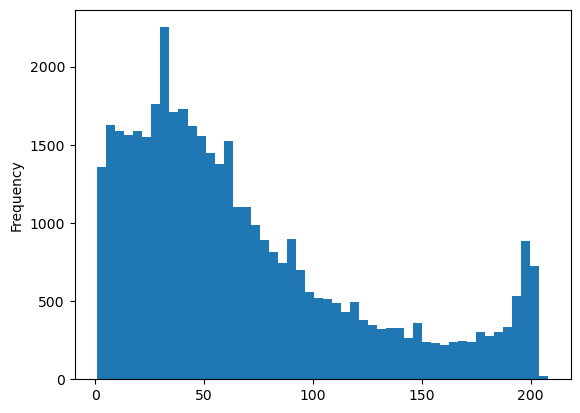

In [92]:
full_reviews['comment_length'].plot(bins=50, kind='hist')

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>, <AxesSubplot:>]], dtype=object)

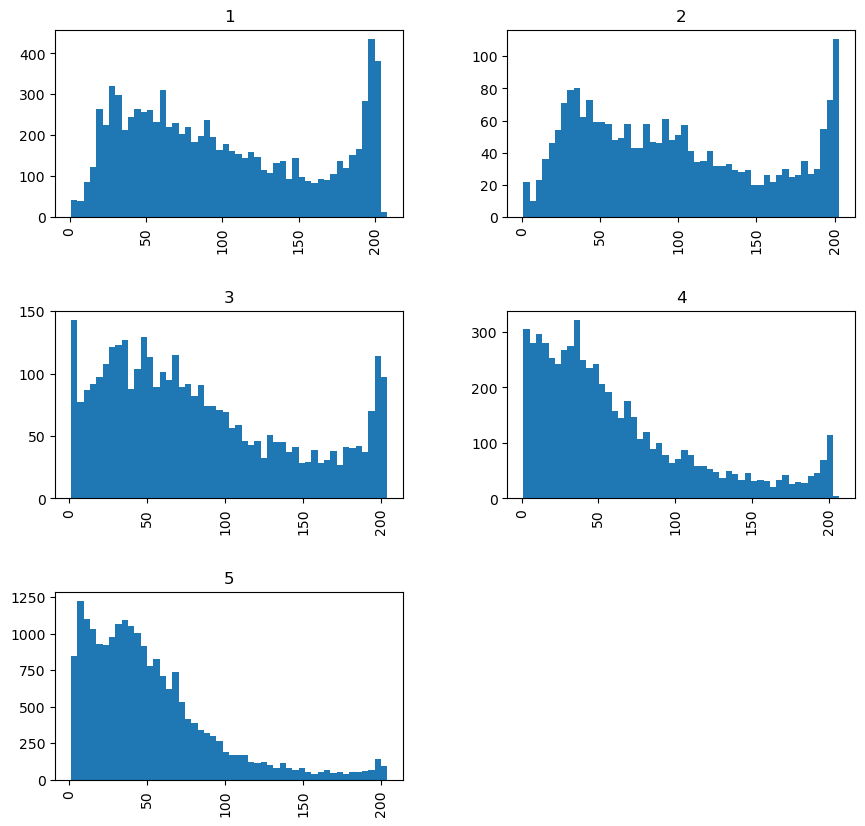

In [93]:
full_reviews.hist(column='comment_length', 
                  by='review_score', 
                  bins=50,
                  figsize=(10,10))

### Preprocess reviews before sentiment analysis

In [94]:
# Apply the preprocess_text function to the 'review_comment_message' column
full_reviews['processed_reviews'] = full_reviews['review_comment_message'].apply(lambda x: preprocess_text(x))

/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/2691866872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['processed_reviews'] = full_reviews['review_comment_message'].apply(lambda x: preprocess_text(x))


In [95]:
full_reviews['review_comment_message'].str.len().sum()

2859280

In [96]:
full_reviews.describe()

,review_score,comment_length
count,41606.000000,41606.000000
mean,3.660674,68.722780
std,1.619193,53.905679
min,1.000000,1.000000
25%,2.000000,28.000000
50%,4.000000,53.000000
75%,5.000000,95.000000
max,5.000000,208.000000


## Valence Aware Dictionary and Sentiment Reasoner

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [97]:
# Split the DataFrame into chunks of 1000 rows each
#chunk_size = 100
#chunks = [full_reviews[i:i+chunk_size] 
#          for i in range(0, len(full_reviews), chunk_size)]

#chunks[1]['reviews_en'] = chunks[1]['review_comment_message'].apply(translate_sentence, args=('pt', 'en'))

# Apply the translation function to each chunk and store the results in a new column
#for i, chunk in enumerate(chunks):
#    chunk['reviews_en'] = chunk['review_comment_message'].apply(translate_sentence, args=('pt', 'en'))
#    print(f"Processed chunk {i+1}/{len(chunks)}")

# Concatenate the chunks back into a single DataFrame
#translated_df = pd.concat(chunks)

# Print the first few rows of the DataFrame to check the results
#print(translated_df.head())

# Convert the 'review_comment_message' column to string
#full_reviews.review_comment_message = full_reviews.review_comment_message.astype(str)

# Apply the translation function to the 'reviews' column and store the results in a new column
#full_reviews['reviews_en'] = full_reviews['review_comment_message'].apply(translate_sentence, args=('pt', 'en'))

# Print the first few rows of the DataFrame to check the results
#full_reviews.head()

In [98]:
## VADER ANALYSIS 
analyzer = SentimentIntensityAnalyzer()

# Define a function to get the compound sentiment score of each comment
def compund_sentiment_score(comment):
    sentiment = analyzer.polarity_scores(comment)
    return sentiment['compound']

# Apply the function to the comments column to get the sentiment scores
full_reviews['VADER_compound_score_processed'] = full_reviews['processed_reviews'].apply(compund_sentiment_score)
full_reviews['VADER_compound_score'] = full_reviews['review_comment_message'].apply(compund_sentiment_score)
full_reviews["sentiment"] = np.select([full_reviews["VADER_compound_score"] < 0, 
                                       full_reviews["VADER_compound_score"] == 0, 
                                       full_reviews["VADER_compound_score"] > 0],
                           ['neg', 'neu', 'pos'])

/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/1442288651.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['VADER_compound_score_processed'] = full_reviews['processed_reviews'].apply(compund_sentiment_score)
/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/1442288651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['VADER_compound_score'] = full_reviews['review_comment_message'].apply(compund_sentiment_score)
/var/folders/m0/0s2csm153y32js1

In [99]:
# Getting pos, neg and neutral scores
#scores = full_reviews['processed_reviews'].apply(lambda comment: analyzer.polarity_scores(comment))
#scores_df = pd.DataFrame(list(scores))

# Add the new columns to the original DataFrame
#VADER_scores = ['neg', 'neu', 'pos']
#for i in VADER_scores:
#    full_reviews[f'VADER_{i}'] = scores_df[i]

# Drop the columns 'VADER_neg', 'VADER_neu', and 'VADER_pos'
#full_reviews.drop(columns=['VADER_neg', 'VADER_neu', 'VADER_pos'], inplace=True)

In [100]:
rating_sorted_dfs = []
for i in range(1, 6):
    rating_sorted_dfs.append([full_reviews[full_reviews["review_score"] == i]])

In [101]:
for rating_df in rating_sorted_dfs:
    print(rating_df[0].describe())

       review_score  comment_length  VADER_compound_score_processed  \
count        8963.0     8963.000000                     8963.000000   
mean            1.0       99.866786                        0.011173   
std             0.0       59.917239                        0.095488   
min             1.0        1.000000                       -0.851900   
25%             1.0       48.000000                        0.000000   
50%             1.0       89.000000                        0.000000   
75%             1.0      151.000000                        0.000000   
max             1.0      208.000000                        0.831600   

       VADER_compound_score  
count           8963.000000  
mean              -0.036087  
std                0.157869  
min               -0.903900  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                0.831600  
       review_score  comment_length  VADER_compound_score_processed  \
count        2201.0

In [102]:
full_reviews['count'] = 1
df_grouped = full_reviews.groupby(["review_score", "sentiment"]).sum()
df_grouped

/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/2442442296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['count'] = 1


comment_length  VADER_compound_score_processed  \
review_score sentiment                                                   
1            neg                188329                        -45.2122   
             neu                653457                          1.9388   
             pos                 53320                        143.4176   
2            neg                 45290                        -10.5128   
             neu                157455                          3.3448   
             pos                 10133                         32.4324   
3            neg                 66290                        -13.6400   
             neu                220137                          4.4400   
             pos                 15134                         58.7515   
4            neg                 68850                         -1.4908   
             neu                279344                         21.3468   
             pos                 25030                        151.5961   
5            neg                134744                          8.5547   
             neu                809900                         42.1974   
             pos                131867                       1061.4161   

                        VADER_compound_score  count  
review_score sentiment                               
1            neg                   -463.2337   1341  
             neu                      0.0000   7220  
             pos                    139.7854    402  
2            neg                   -116.7441    346  
             neu                      0.0000   1770  
             pos                     30.0745     85  
3            neg                   -182.1793    542  
             neu                      0.0000   2908  
             pos                     58.6051    163  
4            neg                   -242.2980    741  
             neu                      0.0000   4966  
             pos                    147.9232    336  
5            neg                   -569.0172   1742  
             neu                      0.0000  16989  
             pos                   1091.9227   2055

In [103]:
evaluate_results(df_grouped)

Accuracy: 61.29963898916968
Precision: 83.63858363858364
Specificity: 76.93631669535283
F1: 65.71794051806843


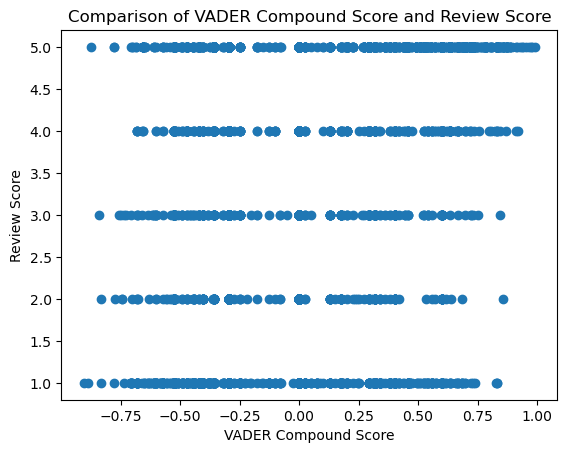

In [104]:
plt.scatter(full_reviews['VADER_compound_score'], full_reviews['review_score'])
plt.xlabel('VADER Compound Score')
plt.ylabel('Review Score')
plt.title('Comparison of VADER Compound Score and Review Score')
plt.show()

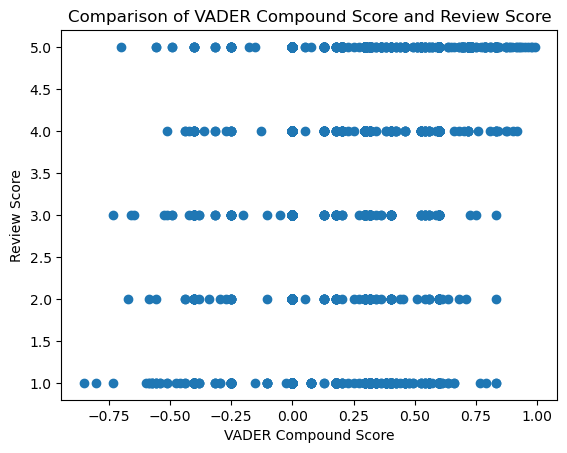

In [105]:
plt.scatter(full_reviews['VADER_compound_score_processed'], full_reviews['review_score'])
plt.xlabel('VADER Compound Score')
plt.ylabel('Review Score')
plt.title('Comparison of VADER Compound Score and Review Score')
plt.show()

## TextBlob

In [106]:
# Getting polarity scores for the reviews
polarity_scores = []
for review in full_reviews['processed_reviews']:
    testimonial = TextBlob(review)
    polarity_scores.append(testimonial.sentiment.polarity)

# Add the polarity scores as a new column to the DataFrame
full_reviews['processed_polarity_score'] = polarity_scores

# Repeating for original comments
polarity_scores = []
for review in full_reviews['review_comment_message']:
    testimonial = TextBlob(review)
    polarity_scores.append(testimonial.sentiment.polarity)

# Add the polarity scores as a new column to the DataFrame
full_reviews['polarity_score'] = polarity_scores
full_reviews["sentiment"] = np.select([full_reviews["polarity_score"] < 0, 
                                       full_reviews["polarity_score"] == 0, 
                                       full_reviews["polarity_score"] > 0],
                           ['neg', 'neu', 'pos'])

/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/2738013640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['processed_polarity_score'] = polarity_scores
/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/2738013640.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_reviews['polarity_score'] = polarity_scores
/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/2738013640.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [107]:
df_grouped = full_reviews.groupby(["review_score", "sentiment"]).sum()
df_grouped

comment_length  VADER_compound_score_processed  \
review_score sentiment                                                   
1            neg                 31150                        -11.3372   
             neu                829326                         23.9993   
             pos                 34630                         87.4821   
2            neg                  4716                         -3.0664   
             neu                198464                          2.1543   
             pos                  9698                         26.1765   
3            neg                  6768                         -2.0000   
             neu                277508                         -3.9740   
             pos                 17285                         55.5255   
4            neg                  5300                         -2.2268   
             neu                335507                         14.0733   
             pos                 32417                        159.6056   
5            neg                 12079                         -1.6288   
             neu                928676                         62.1591   
             pos                135756                       1051.6379   

                        VADER_compound_score  count  processed_polarity_score  \
review_score sentiment                                                          
1            neg                    -32.0048    215                -54.204167   
             neu                   -366.2294   8492                  0.500000   
             pos                     74.7859    256                 84.125000   
2            neg                     -6.3918     35                -10.550000   
             neu                   -100.5804   2088                  0.333333   
             pos                     20.3026     78                 28.212500   
3            neg                     -6.9762     47                -13.666667   
             neu                   -157.5260   3386                  1.000000   
             pos                     40.9280    180                 68.768308   
4            neg                     -6.9223     43                -13.166667   
             neu                   -210.1320   5579                  1.666667   
             pos                    122.6795    421                168.255556   
5            neg                     -6.7717    119                -26.922222   
             neu                   -469.5646  18519                  5.000000   
             pos                    999.2418   2148                784.460952   

                        polarity_score  
review_score sentiment                  
1            neg            -62.570076  
             neu              0.000000  
             pos             90.967039  
2            neg            -13.550000  
             neu              0.000000  
             pos             29.086654  
3            neg            -15.279167  
             neu              0.000000  
             pos             73.415183  
4            neg            -15.829167  
             neu              0.000000  
             pos            179.391395  
5            neg            -30.461285  
             neu              0.000000  
             pos            895.967974

In [108]:
evaluate_results(df_grouped)

Accuracy: 86.30387143900657
Precision: 89.35108153078203
Specificity: 45.64755838641189
F1: 91.97174052665382


## Graphs

In [109]:
# Subsetting the data into negative and positive sentiment
full_reviews_neg = full_reviews[(full_reviews['VADER_compound_score'] < 0)] #| (full_reviews['polarity_score'] < 0)]
full_reviews_pos = full_reviews[(full_reviews['VADER_compound_score'] > 0)] #| (full_reviews['polarity_score'] > 0)]

In [110]:
# Only considering reviews that have a low score in negative and high score in positive
full_reviews_neg = full_reviews_neg[full_reviews_neg['review_score'].isin([1, 2, 3])]
full_reviews_pos = full_reviews_pos[full_reviews_pos['review_score'].isin([3, 4, 5])]

In [111]:
full_reviews_neg[['review_score','VADER_compound_score','polarity_score']].describe()

,review_score,VADER_compound_score,polarity_score
count,2229.000000,2229.000000,2229.000000
mean,1.641543,-0.341928,-0.008991
std,0.846524,0.102343,0.094969
min,1.000000,-0.903900,-1.000000
25%,1.000000,-0.359500,0.000000
50%,1.000000,-0.296000,0.000000
75%,2.000000,-0.296000,0.000000
max,3.000000,-0.025800,0.700000


In [112]:
full_reviews_pos[['review_score','VADER_compound_score','polarity_score']].describe()

,review_score,VADER_compound_score,polarity_score
count,2554.000000,2554.000000,2554.000000
mean,4.740799,0.508399,0.382059
std,0.565495,0.178584,0.176476
min,3.000000,0.025800,-0.200000
25%,5.000000,0.318200,0.333333
50%,5.000000,0.599400,0.333333
75%,5.000000,0.599400,0.500000
max,5.000000,0.990900,1.000000


array([[<AxesSubplot:title={'center':'VADER_compound_score'}>]],
      dtype=object)

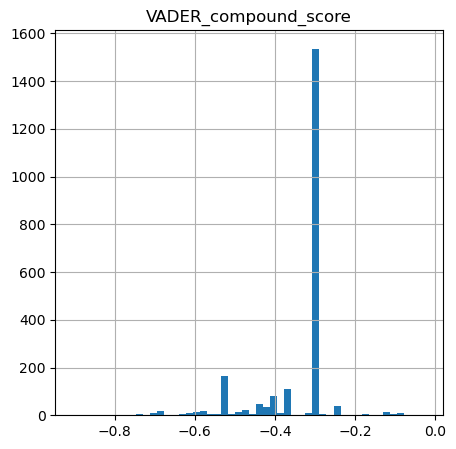

In [113]:
full_reviews_neg.hist(column='VADER_compound_score',  
                  bins=50,
                  figsize=(5,5))

array([[<AxesSubplot:title={'center':'VADER_compound_score'}>]],
      dtype=object)

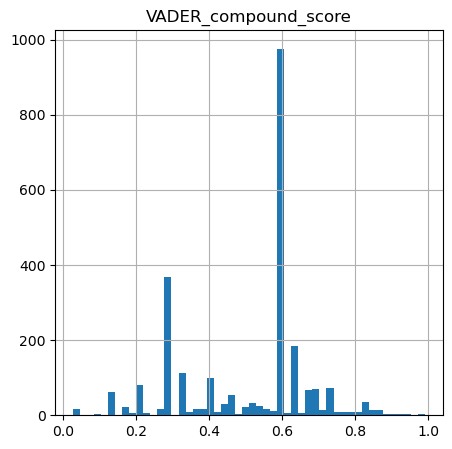

In [114]:
full_reviews_pos.hist(column='VADER_compound_score',  
                  bins=50,
                  figsize=(5,5))

In [115]:
# concatenate all processed_reviews into one string
all_words = ' '.join(full_reviews_neg['processed_reviews'])

# split the string into words
all_words_list = all_words.split()

# count the occurrence of each word
word_freq = Counter(all_words_list)

# get the 10 most common words
top_words = word_freq.most_common(50)

top_words

[('produto', 1448),
 ('recebi', 596),
 ('prazo', 469),
 ('comprei', 423),
 ('dia', 407),
 ('site', 379),
 ('entregue', 377),
 ('entrega', 357),
 ('veio', 347),
 ('chegou', 300),
 ('compra', 266),
 ('ainda', 233),
 ('pedido', 212),
 ('loja', 177),
 ('nao', 176),
 ('porém', 169),
 ('aguardo', 165),
 ('pois', 150),
 ('lannister', 142),
 ('agora', 140),
 ('2', 127),
 ('correio', 126),
 ('outro', 125),
 ('qualidade', 124),
 ('produtos', 116),
 ('dias', 112),
 ('nada', 110),
 ('inferior', 109),
 ('dois', 107),
 ('apenas', 107),
 ('q', 107),
 ('fiz', 104),
 ('1', 103),
 ('bem', 99),
 ('quero', 98),
 ('nota', 97),
 ('paguei', 96),
 ('pra', 96),
 ('frete', 93),
 ('contato', 92),
 ('problema', 89),
 ('valor', 88),
 ('momento', 88),
 ('ter', 86),
 ('correios', 84),
 ('resposta', 79),
 ('cor', 74),
 ('bom', 74),
 ('mercadoria', 73),
 ('vou', 71)]

In [116]:
# concatenate all the processed_reviews into one long string
all_processed_reviews = ' '.join(full_reviews_neg['processed_reviews'].tolist())

# create a list of all the words in the concatenated string
all_words = nltk.tokenize.word_tokenize(all_processed_reviews)

# create a BigramCollocationFinder object and apply some filters
bigram_finder = BigramCollocationFinder.from_words(all_words)
bigram_finder.apply_freq_filter(5)  # only consider bigrams that appear at least 5 times

# get the top 20 bigrams by frequency
bigram_measures = BigramAssocMeasures()
top_20_bigrams = bigram_finder.nbest(bigram_measures.raw_freq, 20)

# create a TrigramCollocationFinder object and apply some filters
trigram_finder = TrigramCollocationFinder.from_words(all_words)
trigram_finder.apply_freq_filter(3)  # only consider trigrams that appear at least 3 times

# get the top 20 trigrams by frequency
trigram_measures = TrigramAssocMeasures()
top_20_trigrams = trigram_finder.nbest(trigram_measures.raw_freq, 20)


# create an empty list to store the bigrams and trigrams
most_common_negative = []

# loop through the top 20 trigrams
for trigram in top_20_trigrams:
    # append each trigram to the list as a string
    most_common_negative.append(' '.join(trigram))

# loop through the top 20 bigrams
for bigram in top_20_bigrams:
    # append each trigram to the list as a string
    most_common_negative.append(' '.join(bigram))

# create a pandas DataFrame with the trigrams as a column
neg_reasons = pd.DataFrame(most_common_negative, columns=['reason'])

# print the DataFrame
print(neg_reasons)

                         reason
0        produto entregue prazo
1          produto chegou prazo
2          ainda recebi produto
3          recebi produto prazo
4               recebi apenas 1
5         comprei dois produtos
6     produto péssima qualidade
7                bom dia recebi
8            chegou prazo porém
9             prazo entrega dia
10       produto ainda entregue
11        site produto entregue
12           comprei 2 produtos
13          entrega feita prazo
14          fiz reclamação site
15         produto ainda chegou
16         produto veio defeito
17  propaganda enganosa produto
18           chegou antes prazo
19          comprei produto dia
20               recebi produto
21             produto entregue
22               produto chegou
23               entregue prazo
24              comprei produto
25                 chegou prazo
26                  nota fiscal
27                 produto veio
28                prazo entrega
29               site lannister
30      

In [117]:
# Data frames with top comments
neg_reasons = get_top_ngrams(full_reviews_neg)
pos_reasons = get_top_ngrams(full_reviews_pos)

In [118]:
# Apply the translation function to the 'phrase' column
neg_reasons['translated'] = neg_reasons['N-gram'].apply(lambda x: translate_sentence(x, 'pt', 'en'))
pos_reasons['translated'] = pos_reasons['N-gram'].apply(lambda x: translate_sentence(x, 'pt', 'en'))

In [119]:
neg_reasons

,N-gram,translated
0,produto entregue prazo,product delivered on time
1,produto chegou prazo,product has reached deadline
2,ainda recebi produto,i still received product
3,recebi produto prazo,received term product
4,recebi apenas 1,received only 1
5,comprei dois produtos,i bought two products
6,produto péssima qualidade,poor quality product
7,bom dia recebi,good morning received
8,chegou prazo porém,the deadline has arrived but
9,prazo entrega dia,Term for delivery


In [120]:
pos_reasons

,N-gram,translated
0,entrega super rápida,super fast delivery
1,chegou antes prazo,arrived before deadline
2,antes prazo super,before super deadline
3,bem antes prazo,well before the deadline
4,super recomendo produto,super recommend product
5,prazo super recomendo,term super recommend
6,super rápida produto,super fast product
7,chegou super rápido,arrived super fast
8,chegou bem antes,arrived well before
9,entrega super rapida,super fast delivery


In [121]:
full_reviews_neg = full_reviews_neg.reset_index(drop=True)
full_reviews_pos = full_reviews_pos.reset_index(drop=True)

full_reviews_neg.to_csv('full_reviews_neg.csv', index=False)
full_reviews_pos.to_csv('full_reviews_pos.csv', index=False)

## Preparing the data for the sales model

In [122]:
sellers

,seller_id,total_price,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,7d13fca15225358621be4086e1eb0964,113628.97,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0
...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0
375,bc8c8d665ec4664d286be0d521722b19,22.50,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0


In [123]:
# Dropping useless columns
sellers = sellers.drop(sellers.columns[[2,3,]], axis = 1)
sellers

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0
...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0


In [124]:
# Merge orders and reviews
orders_review_score = pd.merge(reviews, 
                          order[['order_id','seller_id',
                                 'price', 'freight_cost',
                                 'total_price']], on='order_id')

# Remove double quotes from the 'review_id' column
orders_review_score['review_id'] = orders_review_score['review_id'].str.replace('"', '').str.strip()

# Removing duplicates
orders_review_score = orders_review_score.drop_duplicates()
orders_review_score

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,seller_id,price,freight_cost,total_price
0,﻿7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2021-01-18 00:00:00,2021-01-18 21:46:59,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63,8711.40
2,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2021-01-18 00:00:00,2021-01-18 21:46:59,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63,8711.40
4,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2021-03-10 00:00:00,2021-03-11 03:05:13,8e6d7754bc7e0f22c96d255ebda59eba,79.79,8.30,14497.27
5,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5,2020-07-29 00:00:00,2020-08-01 20:55:50,48436dade18ac8b2bce089ec2a041202,55.90,9.94,12271.71
6,2eab04a8f45efa131d44cf58b37ab595,0191bbb5166d4b9a68df11797d5acfa9,5,2020-08-25 00:00:00,2020-08-28 12:57:25,48436dade18ac8b2bce089ec2a041202,132.90,20.17,12271.71
...,...,...,...,...,...,...,...,...,...
156383,9185f849f32d82e216a4e025e0c50f5c,fffc94f6ce00a00581880bf54a75a037,5,2021-05-11 00:00:00,2021-05-14 12:53:47,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,13685.71
156384,be803f6a93d64719fd685c1cc610918a,fffcd46ef2263f404302a634eb57f7eb,5,2021-07-24 00:00:00,2021-07-25 09:25:29,f3c38ab652836d21de61fb8314b69182,350.00,36.53,1581.00
156385,dbdd81cd59a1a9f94a10a990b4d48dce,fffce4705a9662cd70adb13d4a31832d,5,2020-10-29 00:00:00,2020-10-29 21:33:52,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,43048.18
156386,fba117c9ac40d41ca7be54741f471303,fffe18544ffabc95dfada21779c9644f,5,2020-08-17 00:00:00,2020-08-18 12:24:05,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,23629.15


In [125]:
# Convert rebiew score column to float type
orders_review_score['review_score'] = orders_review_score['review_score'].astype(float)

In [126]:
# Group orders_reviews by seller_id and calculate the mean review_score for each group
avg_review_score_by_seller = orders_review_score.groupby('seller_id')['review_score'].mean()

In [127]:
#Adding the avg_review_score_by_seller to the original dataframe
orders_review_score['avg_review_score_by_seller'] = orders_review_score['seller_id'].map(avg_review_score_by_seller)
orders_review_score.rename(columns = {'seller_id':'seller_id1'}, inplace = True)
orders_review_score

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,seller_id1,price,freight_cost,total_price,avg_review_score_by_seller
0,﻿7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4.0,2021-01-18 00:00:00,2021-01-18 21:46:59,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63,8711.40,4.245902
2,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4.0,2021-01-18 00:00:00,2021-01-18 21:46:59,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63,8711.40,4.245902
4,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5.0,2021-03-10 00:00:00,2021-03-11 03:05:13,8e6d7754bc7e0f22c96d255ebda59eba,79.79,8.30,14497.27,3.663158
5,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5.0,2020-07-29 00:00:00,2020-08-01 20:55:50,48436dade18ac8b2bce089ec2a041202,55.90,9.94,12271.71,4.034722
6,2eab04a8f45efa131d44cf58b37ab595,0191bbb5166d4b9a68df11797d5acfa9,5.0,2020-08-25 00:00:00,2020-08-28 12:57:25,48436dade18ac8b2bce089ec2a041202,132.90,20.17,12271.71,4.034722
...,...,...,...,...,...,...,...,...,...,...
156383,9185f849f32d82e216a4e025e0c50f5c,fffc94f6ce00a00581880bf54a75a037,5.0,2021-05-11 00:00:00,2021-05-14 12:53:47,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,13685.71,4.318182
156384,be803f6a93d64719fd685c1cc610918a,fffcd46ef2263f404302a634eb57f7eb,5.0,2021-07-24 00:00:00,2021-07-25 09:25:29,f3c38ab652836d21de61fb8314b69182,350.00,36.53,1581.00,4.266667
156385,dbdd81cd59a1a9f94a10a990b4d48dce,fffce4705a9662cd70adb13d4a31832d,5.0,2020-10-29 00:00:00,2020-10-29 21:33:52,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,43048.18,4.468310
156386,fba117c9ac40d41ca7be54741f471303,fffe18544ffabc95dfada21779c9644f,5.0,2020-08-17 00:00:00,2020-08-18 12:24:05,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,23629.15,4.365385


In [128]:
orders_review_score_subset = orders_review_score[['seller_id1', 'avg_review_score_by_seller']]
orders_review_score_subset = orders_review_score_subset.drop_duplicates()
orders_review_score_subset

,seller_id1,avg_review_score_by_seller
0,6d803cb79cc31c41c4c789a75933b3c7,4.245902
4,8e6d7754bc7e0f22c96d255ebda59eba,3.663158
5,48436dade18ac8b2bce089ec2a041202,4.034722
7,a1043bafd471dff536d0c462352beb48,4.213001
8,dd7ddc04e1b6c2c614352b383efe2d36,3.852459
...,...,...
155170,d1aa1ec0839dcab73a6161130eb1f94a,4.000000
155310,dbc51f5e45d654ecc16cb68e6817ecea,4.000000
155546,3fefda3299e6dfaea3466ef346a3571a,4.000000
155707,4e2627090e6e5b9fabba883a37897683,1.000000


In [129]:
# Adding avg score
sellers2 = pd.merge(sellers, orders_review_score_subset, left_on='seller_id', right_on='seller_id1', how='left')
sellers2

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,seller_id1,avg_review_score_by_seller
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,7d13fca15225358621be4086e1eb0964,4.021352
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,ba90964cff9b9e0e6f32b23b82465f7b,4.421053
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,c70c1b0d8ca86052f45a432a38b73958,4.354962
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,612170e34b97004b3ba37eae81836b4c,4.429907
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,6061155addc1e54b4cfb51c1c2a32ad8,4.677419
...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5e063e85d44b0f5c3e6ec3131103a57e,5.000000
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,bc8c8d665ec4664d286be0d521722b19,2.000000
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,455befea1bb853c75ccbca94cff26e5c,3.000000
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,bb7ad8a45c027be8ab075b8e465f8ca0,5.000000


In [130]:
sellers3 = pd.merge(sellers2, merchants, left_on='seller_id', right_on='merchant_id', how='left')
sellers3 = pd.merge(sellers3, leads, left_on='lead_id', right_on='lead_id', how='left')
sellers4 = sellers3[['seller_id', 'origin']]
sellers4

,seller_id,origin
0,7d13fca15225358621be4086e1eb0964,unknown
1,ba90964cff9b9e0e6f32b23b82465f7b,organic_search
2,c70c1b0d8ca86052f45a432a38b73958,paid_search
3,612170e34b97004b3ba37eae81836b4c,organic_search
4,6061155addc1e54b4cfb51c1c2a32ad8,organic_search
...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,organic_search
375,bc8c8d665ec4664d286be0d521722b19,organic_search
376,455befea1bb853c75ccbca94cff26e5c,organic_search
377,bb7ad8a45c027be8ab075b8e465f8ca0,paid_search


In [131]:
sellers2 = pd.merge(sellers2, sellers4, left_on='seller_id', right_on='seller_id', how='left')
sellers2 = sellers2.drop(sellers2.columns[-3], axis = 1)
sellers2

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search
...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search


In [132]:
#Avg freight costs per seller
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112629 entries, 0 to 112628
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         112629 non-null  object 
 1   order_line_item  112629 non-null  object 
 2   product_id       112629 non-null  object 
 3   seller_id        112629 non-null  object 
 4   order_date_time  112629 non-null  object 
 5   price            112629 non-null  float64
 6   freight_cost     112629 non-null  object 
 7   total_price      112629 non-null  float64
dtypes: float64(2), object(6)
memory usage: 6.9+ MB


In [133]:
order['freight_cost'] = order['freight_cost'].astype(float)
avg_freight_cost_by_seller = order.groupby('seller_id')['freight_cost'].mean()
avg_freight_cost_by_seller_df = pd.DataFrame({'avg_freight_cost': avg_freight_cost_by_seller})
avg_freight_cost_by_seller_df

,avg_freight_cost
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,21.020000
001cca7ae9ae17fb1caed9dfb1094831,37.046611
001e6ad469a905060d959994f1b41e4f,17.940000
002100f778ceb8431b7a1020ff7ab48f,14.430182
003554e2dce176b5555353e4f3555ac8,19.380000
...,...
ffcfefa19b08742c5d315f2791395ee5,9.620000
ffdd9f82b9a447f6f8d4b91554cc7dd3,36.373000
ffeee66ac5d5a62fe688b9d26f83f534,29.977857


In [134]:
sellers4 = pd.merge(sellers2, avg_freight_cost_by_seller_df, left_on='seller_id', right_on='seller_id', how='left')
sellers4 

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939
...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000


In [135]:
date = pd.merge(sellers4, merchants, left_on='seller_id', right_on='merchant_id', how='left')
date

,seller_id,total_price,business_segment_x,lead_behavior_x,business_type_x,declared_monthly_revenue_x,avg_review_score_by_seller,origin,avg_freight_cost,merchant_id,lead_id,business_segment_y,lead_behavior_y,business_type_y,declared_monthly_revenue_y
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0


In [136]:
date1 = pd.merge(date, leads, left_on='lead_id', right_on='lead_id', how='left')
date1

,seller_id,total_price,business_segment_x,lead_behavior_x,business_type_x,declared_monthly_revenue_x,avg_review_score_by_seller,origin_x,avg_freight_cost,merchant_id,lead_id,business_segment_y,lead_behavior_y,business_type_y,declared_monthly_revenue_y,registered_on_landing_page_date,landing_page_id,origin_y
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,7d13fca15225358621be4086e1eb0964,0b97be8b4b408a3a0780a32e0a143a7f,watches,Influence / Yellow,reseller,0.0,2021-01-22,b76ef37428e6799c421989521c0e5077,unknown
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,ba90964cff9b9e0e6f32b23b82465f7b,8257329475414b1eaf3dc731440e01a7,small_appliances,Stability / Green,reseller,0.0,2021-01-30,22c29808c4f815213303f8933030604c,organic_search
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,c70c1b0d8ca86052f45a432a38b73958,7b6ad2297d3beb569ddf3ee1ce22ffa8,health_beauty,Dominant / Red,reseller,0.0,2021-03-13,22c29808c4f815213303f8933030604c,paid_search
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,612170e34b97004b3ba37eae81836b4c,327174d3648a2d047e8940d7d15204ca,home_appliances,Stability / Green,reseller,0.0,2021-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,6061155addc1e54b4cfb51c1c2a32ad8,8d6be534a8bdd08e11efe57c6ce3dd21,pet,Stability / Green,reseller,0.0,2021-04-05,22c29808c4f815213303f8933030604c,organic_search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0,2021-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,bc8c8d665ec4664d286be0d521722b19,5f7526ec1bdd6eebdf4f7d0054cfe163,food_drink,Conformity / Blue,reseller,0.0,2021-01-06,50f87b85a731cec08d8380b08c573ed3,organic_search
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,455befea1bb853c75ccbca94cff26e5c,28f36aa85fbadc0663c2df15a5af35db,phone_mobile,Stability / Green,reseller,0.0,2021-04-18,f017be4dbf86243af5c1ebed0cff36a2,organic_search
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,bb7ad8a45c027be8ab075b8e465f8ca0,47a752e75a196b3b4edd825252ccf97f,household_utilities,Stability / Green,manufacturer,0.0,2021-03-07,fe82aeadeaea2186478fe6353d6d5301,paid_search


In [137]:
date1_subset = date1[['seller_id', 'registered_on_landing_page_date']]
date1_subset

,seller_id,registered_on_landing_page_date
0,7d13fca15225358621be4086e1eb0964,2021-01-22
1,ba90964cff9b9e0e6f32b23b82465f7b,2021-01-30
2,c70c1b0d8ca86052f45a432a38b73958,2021-03-13
3,612170e34b97004b3ba37eae81836b4c,2021-04-03
4,6061155addc1e54b4cfb51c1c2a32ad8,2021-04-05
...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,2021-03-08
375,bc8c8d665ec4664d286be0d521722b19,2021-01-06
376,455befea1bb853c75ccbca94cff26e5c,2021-04-18
377,bb7ad8a45c027be8ab075b8e465f8ca0,2021-03-07


In [138]:
sellers4 = pd.merge(sellers4, date1_subset, left_on='seller_id', right_on='seller_id', how='left')
sellers4

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost,registered_on_landing_page_date
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,2021-01-22
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,2021-01-30
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,2021-03-13
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,2021-04-03
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,2021-04-05
...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,2021-03-08
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,2021-01-06
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,2021-04-18
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,2021-03-07


In [139]:
sellers5 = pd.merge(sellers4, order, left_on='seller_id', right_on='seller_id', how='left')
origin_subset = sellers5[['seller_id', 'order_date_time']]
origin_subset

,seller_id,order_date_time
0,7d13fca15225358621be4086e1eb0964,2021-05-15 04:31:26
1,7d13fca15225358621be4086e1eb0964,2021-03-15 02:30:23
2,7d13fca15225358621be4086e1eb0964,2021-08-20 08:50:19
3,7d13fca15225358621be4086e1eb0964,2021-04-03 09:30:27
4,7d13fca15225358621be4086e1eb0964,2021-08-28 14:51:17
...,...,...
5018,bc8c8d665ec4664d286be0d521722b19,2021-08-09 15:15:17
5019,455befea1bb853c75ccbca94cff26e5c,2021-06-18 03:13:26
5020,bb7ad8a45c027be8ab075b8e465f8ca0,2021-08-02 13:44:32
5021,bb7ad8a45c027be8ab075b8e465f8ca0,2021-07-27 11:03:55


In [277]:
# Getting the cylces
# Merge all files to one table 
all_data= pd.merge(merchants,leads, on='lead_id', how='inner')
all_data=pd.merge(all_data, order, left_on='merchant_id', right_on='seller_id', how='inner')
all_data=pd.merge(all_data,merchants_W,on='merchant_id',how='inner')
all_data=pd.merge(all_data,reviews,on='order_id',how='inner')
all_data.columns

Index(['merchant_id', 'lead_id', 'business_segment', 'lead_behavior',
       'business_type', 'declared_monthly_revenue',
       'registered_on_landing_page_date', 'landing_page_id', 'origin',
       'order_id', 'order_line_item', 'product_id', 'seller_id',
       'order_date_time', 'price', 'freight_cost', 'total_price',
       'won_date_ie_date_of_first_saas_payment', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

In [278]:
# Transtalte datatype to datetime
all_data['won_date_ie_date_of_first_saas_payment'] = pd.to_datetime(all_data['won_date_ie_date_of_first_saas_payment'])
all_data['registered_on_landing_page_date'] = pd.to_datetime(all_data['registered_on_landing_page_date'])

# Calculating cycle
all_data['cycle'] = all_data['won_date_ie_date_of_first_saas_payment']- all_data['registered_on_landing_page_date']

# Transtalte datatype to datetime
all_data['order_date'] = pd.to_datetime(all_data['order_date_time']).dt.date

# Make table to get first order date 
first_order_table=all_data[['seller_id','order_date']].groupby('seller_id').min()

# Change column name from 'order_date' to 'first_order_date'
first_order_table = first_order_table.rename(columns={'order_date': 'first_order_date'})

# Merge first_order_table with all_data
all_data=pd.merge(all_data,first_order_table,on='seller_id',how='inner')


# Transtalte datatype to datetime
all_data['first_order_date'] = pd.to_datetime(all_data['first_order_date'])

#Calculating cycle2
all_data['cycle2'] = all_data['first_order_date'] - all_data['won_date_ie_date_of_first_saas_payment']

# Check whether or not cycle2 has negative values
all_data['cycle2'].sort_values(ascending=True)

6357     8 days
6358     8 days
6359     8 days
6360     8 days
6356     8 days
         ...   
134    198 days
139    198 days
137    198 days
136    198 days
5814   225 days
Name: cycle2, Length: 6712, dtype: timedelta64[ns]

In [279]:
# Check whether or not cycle has negative values
all_data['cycle'].sort_values(ascending=True)

1930    -2 days
4765     0 days
4764     0 days
4763     0 days
4762     0 days
         ...   
253    328 days
247    328 days
1531   341 days
367    369 days
368    369 days
Name: cycle, Length: 6712, dtype: timedelta64[ns]

In [280]:
#Translate cycle and cycle2 to INT 
all_data['Int_cycle'] = (all_data["cycle"] / timedelta(days=1))
all_data['Int_cycle2'] = (all_data["cycle2"] / timedelta(days=1))

In [281]:
all_data[all_data['Int_cycle']<0]

,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue,registered_on_landing_page_date,landing_page_id,origin,order_id,...,review_id,review_score,review_creation_date,review_answer_timestamp,cycle,order_date,first_order_date,cycle2,Int_cycle,Int_cycle2
1930,5e063e85d44b0f5c3e6ec3131103a57e,b91cf8812365f50ff4bda4bcd6206b05,health_beauty,Stability / Green,reseller,0.0,2021-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search,ce9e623dd0def1f905a5c5ba0c99f65a,...,28099406ffefbaa66085cb05bf540a75,5,2021-07-14 00:00:00,2021-07-16 11:07:09,-2 days,2021-07-18,2021-07-18,134 days,-2.0,134.0


In [282]:
#row number 1356's saas payment date was earlier than landing_page date, so remove here.
all_data = all_data[all_data['Int_cycle'] >= 0]

In [283]:
#Calculate the sum of price per merchant_id
sum_price_table=all_data.groupby('merchant_id')['price'].sum().reset_index().rename(columns={'price': 'sum_price'})

#Merge sum_price_table with all table 
all_data=pd.merge(all_data,sum_price_table,on='merchant_id',how='inner')

all_data.head()

,merchant_id,lead_id,business_segment,lead_behavior,business_type,declared_monthly_revenue,registered_on_landing_page_date,landing_page_id,origin,order_id,...,review_score,review_creation_date,review_answer_timestamp,cycle,order_date,first_order_date,cycle2,Int_cycle,Int_cycle2,sum_price
0,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0,2021-05-07,b76ef37428e6799c421989521c0e5077,unknown,6826d5740591909e368433e2a5ec75fb,...,5,2021-08-8 00:00:00,2021-08-14 16:22:01,11 days,2021-08-08,2021-08-08,82 days,11.0,82.0,90.25
1,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0,2021-05-07,b76ef37428e6799c421989521c0e5077,unknown,d3582fd5ccccd9cb229a63dfb417c86f,...,5,2021-08-25 00:00:00,2021-08-25 19:35:04,11 days,2021-08-22,2021-08-08,82 days,11.0,82.0,90.25
2,01266d4c46afa519678d16a8b683d325,ae437864746ae2a9e694a6ed2b5824db,construction_tools_house_garden,Stability / Green,reseller,0.0,2021-05-07,b76ef37428e6799c421989521c0e5077,unknown,ed76528f7ed5ae1f2a0dd070a7426d44,...,5,2021-08-29 00:00:00,2021-08-31 23:30:45,11 days,2021-08-23,2021-08-08,82 days,11.0,82.0,90.25
3,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,household_utilities,Stability / Green,reseller,0.0,2021-03-28,b76ef37428e6799c421989521c0e5077,unknown,0c89556cf6859f7e4b104f2883aa1b97,...,4,2021-07-27 00:00:00,2021-07-27 20:48:55,0 days,2021-07-26,2021-04-20,23 days,0.0,23.0,2077.00
4,01fd077212124329bac32490e8ef80d9,180d9ac0990bb42907fe9cc7aa3eb5a1,household_utilities,Stability / Green,reseller,0.0,2021-03-28,b76ef37428e6799c421989521c0e5077,unknown,0c89556cf6859f7e4b104f2883aa1b97,...,4,2021-07-27 00:00:00,2021-07-27 20:48:55,0 days,2021-07-26,2021-04-20,23 days,0.0,23.0,2077.00


In [284]:
all_data_subset = all_data[['seller_id', 'Int_cycle', 'Int_cycle2']]
all_data_subset

,seller_id,Int_cycle,Int_cycle2
0,01266d4c46afa519678d16a8b683d325,11.0,82.0
1,01266d4c46afa519678d16a8b683d325,11.0,82.0
2,01266d4c46afa519678d16a8b683d325,11.0,82.0
3,01fd077212124329bac32490e8ef80d9,0.0,23.0
4,01fd077212124329bac32490e8ef80d9,0.0,23.0
...,...,...,...
6706,ffc470761de7d0232558ba5e786e57b7,30.0,12.0
6707,ffc470761de7d0232558ba5e786e57b7,30.0,12.0
6708,ffc470761de7d0232558ba5e786e57b7,30.0,12.0
6709,ffc470761de7d0232558ba5e786e57b7,30.0,12.0


In [285]:
# drop duplicates
cycles = all_data_subset.drop_duplicates()

# reset index
cycles = cycles.reset_index(drop=True)
cycles

,seller_id,Int_cycle,Int_cycle2
0,01266d4c46afa519678d16a8b683d325,11.0,82.0
1,01fd077212124329bac32490e8ef80d9,0.0,23.0
2,02f623a8eb246f3c5f7c2f96462654e6,2.0,14.0
3,03a2a6dcbe45d639c4dc2a0d24769c40,4.0,38.0
4,044668ccd5316b12a7cf0d54a156e3e9,8.0,198.0
...,...,...,...
373,fd435faa3c0422b60440ea3480d0e77c,126.0,28.0
374,fe87f472055fbcf1d7e691c00b1560dc,5.0,108.0
375,ffa6adafb71b807dc13159e26431354c,6.0,30.0
376,ffad1e7127fb622cb64a900751590acd,1.0,45.0


In [286]:
sellers4

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost,registered_on_landing_page_date
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,2021-01-22
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,2021-01-30
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,2021-03-13
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,2021-04-03
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,2021-04-05
...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,2021-03-08
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,2021-01-06
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,2021-04-18
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,2021-03-07


In [319]:
sales = pd.merge(sellers4, cycles, left_on='seller_id', right_on='seller_id', how='left')
sales

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost,registered_on_landing_page_date,Int_cycle,Int_cycle2
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,2021-01-22,17.0,12.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,2021-01-30,10.0,20.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,2021-03-13,0.0,30.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,2021-04-03,63.0,10.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,2021-04-05,22.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,2021-03-08,NaN,NaN
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,2021-01-06,101.0,114.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,2021-04-18,2.0,59.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,2021-03-07,75.0,67.0


In [320]:
sales = sales.drop(sales.columns[-3], axis = 1)
sales

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost,Int_cycle,Int_cycle2
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,17.0,12.0
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,10.0,20.0
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,0.0,30.0
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,63.0,10.0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,22.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...
374,5e063e85d44b0f5c3e6ec3131103a57e,22.90,health_beauty,Stability / Green,reseller,0.0,5.000000,organic_search,7.420000,NaN,NaN
375,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,101.0,114.0
376,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,2.0,59.0
377,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,75.0,67.0


In [482]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 0 to 6710
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   merchant_id                             6711 non-null   object         
 1   lead_id                                 6711 non-null   object         
 2   business_segment                        6711 non-null   object         
 3   lead_behavior                           6711 non-null   object         
 4   business_type                           6711 non-null   object         
 5   declared_monthly_revenue                6711 non-null   object         
 6   registered_on_landing_page_date         6711 non-null   datetime64[ns] 
 7   landing_page_id                         6711 non-null   object         
 8   origin                                  6711 non-null   object         
 9   order_id                                6

In [534]:
# Table for reviews vs sales over time graph

delta_sales = all_data[['order_id', 'merchant_id', 'order_date', 
                        'price', 'review_score']]

# Transtalte datatype to datetime
delta_sales['order_date'] = pd.to_datetime(delta_sales['order_date'])
delta_sales['order_month'] = delta_sales['order_date'].dt.month
delta_sales['order_year'] = delta_sales['order_date'].dt.year
delta_sales['month_yr'] = delta_sales['order_month'].astype(str) + '_' + delta_sales['order_year'].astype(str)

delta_sales = delta_sales.drop_duplicates().reset_index(drop = True)


/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/1418603629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_sales['order_date'] = pd.to_datetime(delta_sales['order_date'])
/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/1418603629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_sales['order_month'] = delta_sales['order_date'].dt.month
/var/folders/m0/0s2csm153y32js16wzmw40ch0000gn/T/ipykernel_29325/1418603629.py:9: SettingWithCopyWarning: 
A value is tryi

In [542]:
# Calculate sales for each merchant and month
sales_by_month_merchant = delta_sales.groupby(['merchant_id', 'month_yr'])['price'].sum().reset_index()
sales_by_month_merchant = sales_by_month_merchant.rename(columns={'price': 'sales'})

# Merge sales data to the original dataframe
delta_sales = pd.merge(delta_sales, sales_by_month_merchant, on=['merchant_id', 'month_yr'], how='left')

In [545]:
delta_sales.to_csv('delta sales x reviews.csv')

## K-means clustering

In [289]:
#Make the new table for applying to Kmeans model
df=all_data.loc[:,['merchant_id','origin','Int_cycle','Int_cycle2',
                   'business_segment','business_type','sum_price',
                   'freight_cost','price', 'review_score'
                  ]]
df.head()

,merchant_id,origin,Int_cycle,Int_cycle2,business_segment,business_type,sum_price,freight_cost,price,review_score
0,01266d4c46afa519678d16a8b683d325,unknown,11.0,82.0,construction_tools_house_garden,reseller,90.25,13.47,9.88,5
1,01266d4c46afa519678d16a8b683d325,unknown,11.0,82.0,construction_tools_house_garden,reseller,90.25,15.26,23.40,5
2,01266d4c46afa519678d16a8b683d325,unknown,11.0,82.0,construction_tools_house_garden,reseller,90.25,18.50,56.97,5
3,01fd077212124329bac32490e8ef80d9,unknown,0.0,23.0,household_utilities,reseller,2077.00,12.93,38.00,4
4,01fd077212124329bac32490e8ef80d9,unknown,0.0,23.0,household_utilities,reseller,2077.00,12.93,38.00,4


In [290]:
#Translating all characters to dummy valuables
le_mid = LabelEncoder()
le_or = LabelEncoder()
le_bs = LabelEncoder()
le_bt = LabelEncoder()

df['merchant_id'] = le_mid.fit_transform(df['merchant_id'])
df['origin'] = le_or.fit_transform(df['origin'])
df['business_segment'] = le_bs.fit_transform(df['business_segment'])
df['business_type'] = le_bt.fit_transform(df['business_type'])

# Correct data type
df['review_score'] = df['review_score'].astype(int)

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 0 to 6710
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   merchant_id       6711 non-null   int64  
 1   origin            6711 non-null   int64  
 2   Int_cycle         6711 non-null   float64
 3   Int_cycle2        6711 non-null   float64
 4   business_segment  6711 non-null   int64  
 5   business_type     6711 non-null   int64  
 6   sum_price         6711 non-null   float64
 7   freight_cost      6711 non-null   float64
 8   price             6711 non-null   float64
 9   review_score      6711 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 576.7 KB


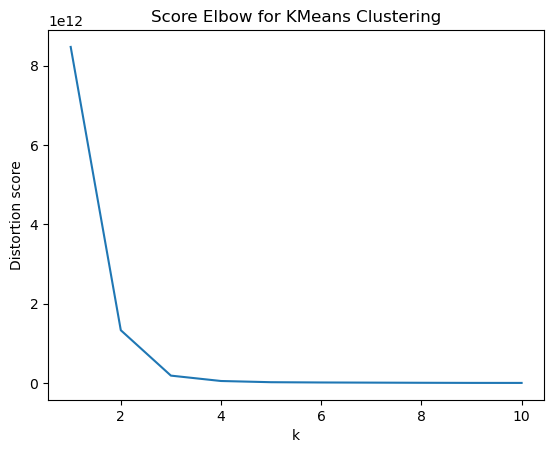

In [292]:
# Calculating the most appropriate number of cluster

km_eval = []

for i in range(1,11):
    kmeans_model=KMeans(n_clusters=i,init='k-means++', max_iter=300,
                        n_init=10, random_state=0)
    kmeans_model.fit(df)
    km_eval.append(kmeans_model.inertia_)

# Plot Kmeans for k from 1 to 10 criterion
plt.plot(range(1,11), km_eval)
plt.title('Score Elbow for KMeans Clustering')
plt.xlabel('k')
plt.ylabel('Distortion score')
plt.show()

In [293]:
#Applying K means model
kmeans_model = KMeans(n_clusters=3, init='k-means++', 
                      max_iter=300, n_init=10, random_state=0)
df['cluster'] = kmeans_model.fit_predict(df)

In [294]:
# Checking the number of values per cluster
df['cluster'].value_counts()

0    5507
1     627
2     577
Name: cluster, dtype: int64

In [295]:
# Checking the average price per cluster
df.groupby('cluster')['price'].mean()

cluster
0    110.786056
1    190.630255
2    177.364419
Name: price, dtype: float64

In [296]:
# Checking the average cycle (won_date_ie_date_of_first_saas_payment- registered_on_landing_page_date)

df.groupby('cluster')['Int_cycle'].mean()

cluster
0    23.956601
1    17.000000
2     0.658579
Name: Int_cycle, dtype: float64

In [297]:
# Checking the average cycle2(first_order_date' - won_date_ie_date_of_first_saas_payment)
df.groupby('cluster')['Int_cycle2'].mean()

cluster
0    40.476121
1    12.000000
2    29.341421
Name: Int_cycle2, dtype: float64

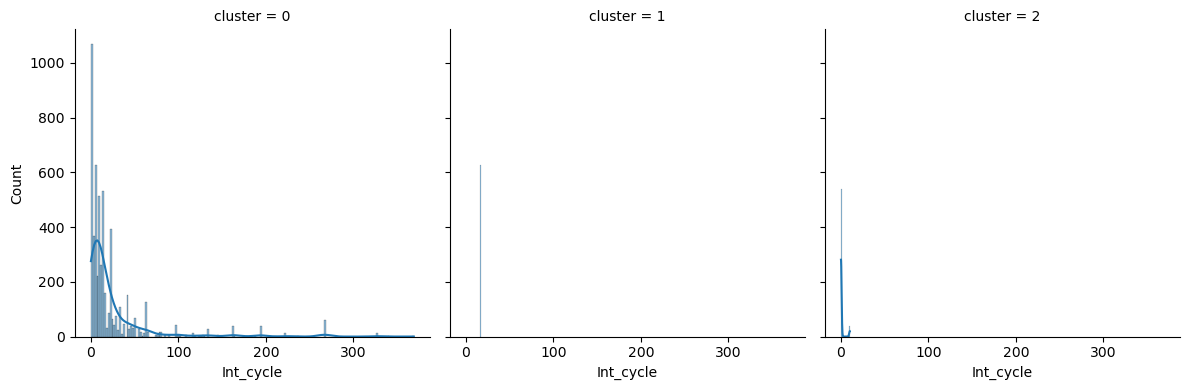

In [298]:
# Plot a histogram of Int_cycle in the first axis
g = sns.FacetGrid(df, col="cluster", height=4, aspect=1)
g.map(sns.histplot, "Int_cycle", kde=True)

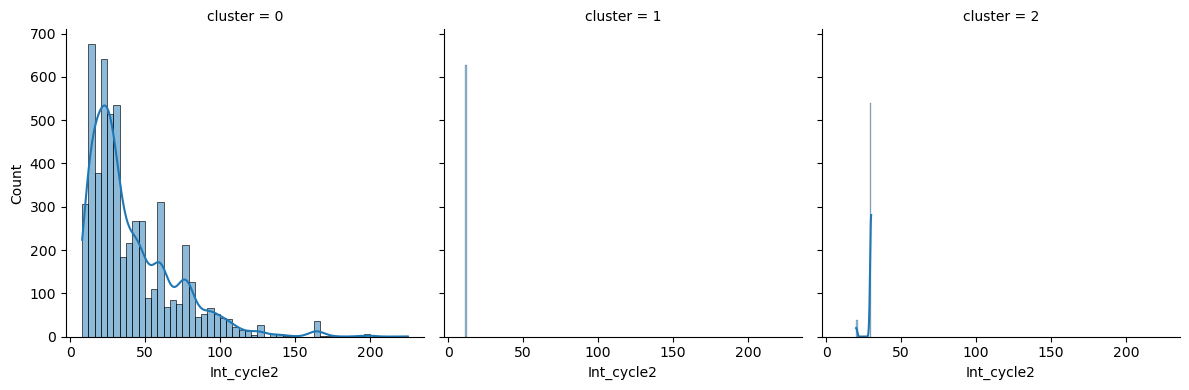

In [299]:
# Plot a histogram of Int_cycle2 in the first axis
g = sns.FacetGrid(df, col="cluster", height=4, aspect=1)
g.map(sns.histplot, "Int_cycle2", kde=True)

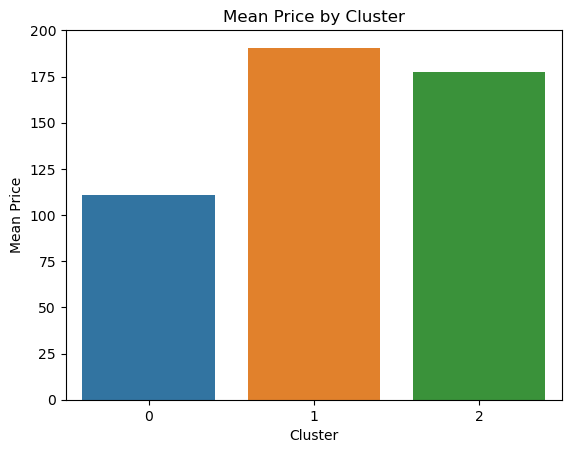

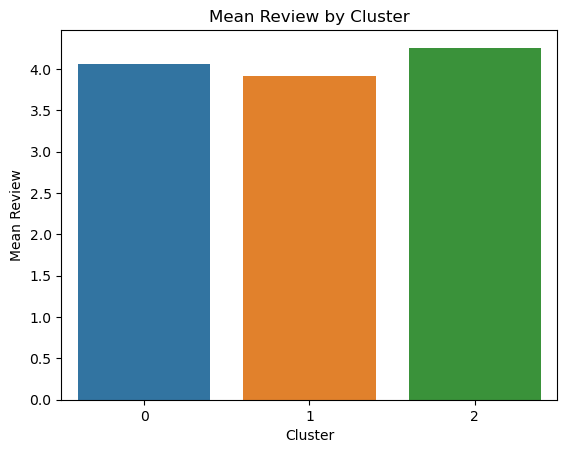

In [300]:
# Calculating the average of price and review per cluster
mean_price_by_cluster = df.groupby('cluster')['price'].mean()
mean_review_by_cluster = df.groupby('cluster')['review_score'].mean()

# Making barchart
sns.barplot(x=mean_price_by_cluster.index, y=mean_price_by_cluster.values)

# Adding the title and labels of x and y axis
plt.title('Mean Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Price')

# Display graph
plt.show()

# Making barchart
sns.barplot(x=mean_review_by_cluster.index, y=mean_review_by_cluster.values)

# Adding the title and labels of x and y axis
plt.title('Mean Review by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Review')

# Display graph
plt.show()

In [301]:
# Undo dummy variables
df['merchant_id'] = le_mid.inverse_transform(df['merchant_id'])
df['origin'] = le_or.inverse_transform(df['origin'])
df['business_segment'] = le_bs.inverse_transform(df['business_segment'])
df['business_type'] = le_bt.inverse_transform(df['business_type'])

In [302]:
# Count 'business_segment'values per cluster
df.groupby('cluster')['business_segment'].value_counts()

cluster  business_segment               
0        home_decor                         796
         household_utilities                773
         health_beauty                      592
         construction_tools_house_garden    489
         audio_video_electronics            400
         pet                                400
         bed_bath_table                     254
         car_accessories                    209
         sports_leisure                     199
         computers                          189
         home_appliances                    157
         bags_backpacks                     147
         toys                               140
         books                              111
         food_supplement                    109
         home_office_furniture              102
         food_drink                          78
         stationery                          69
         phone_mobile                        68
         fashion_accessories                 67

In [303]:
# Count 'business_type'values per cluster
df.groupby('cluster')['business_type'].value_counts()

cluster  business_type
0        reseller         4497
         manufacturer     1010
1        reseller          627
2        reseller          577
Name: business_type, dtype: int64

In [304]:
# # Count 'origin'values per cluster
df.groupby('cluster')['origin'].value_counts()

cluster  origin        
0        organic_search    1795
         paid_search       1473
         unknown           1065
         social             587
         direct_traffic     312
         other              127
         referral           114
         email               27
         display              7
1        unknown            627
2        paid_search        539
         organic_search      38
Name: origin, dtype: int64

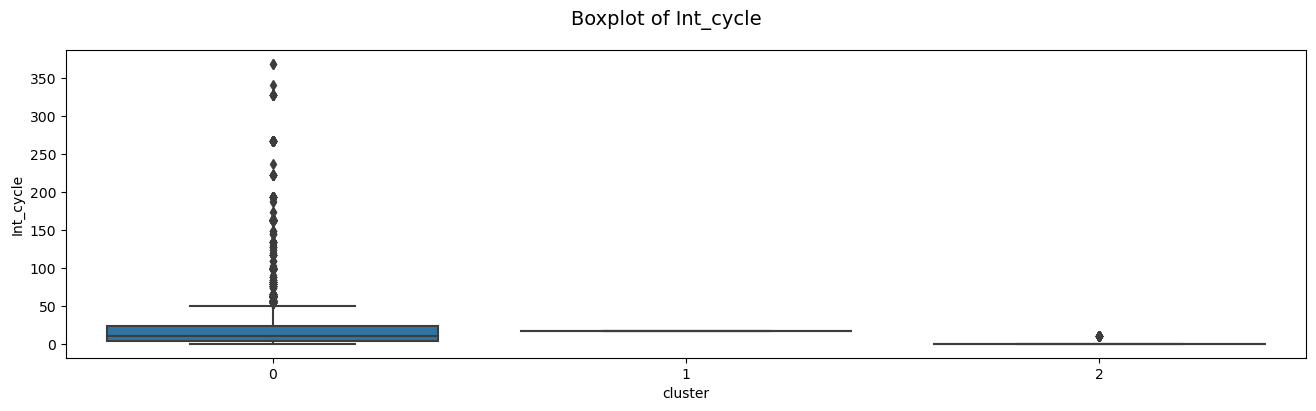

------------------------------------------------------------------------------------





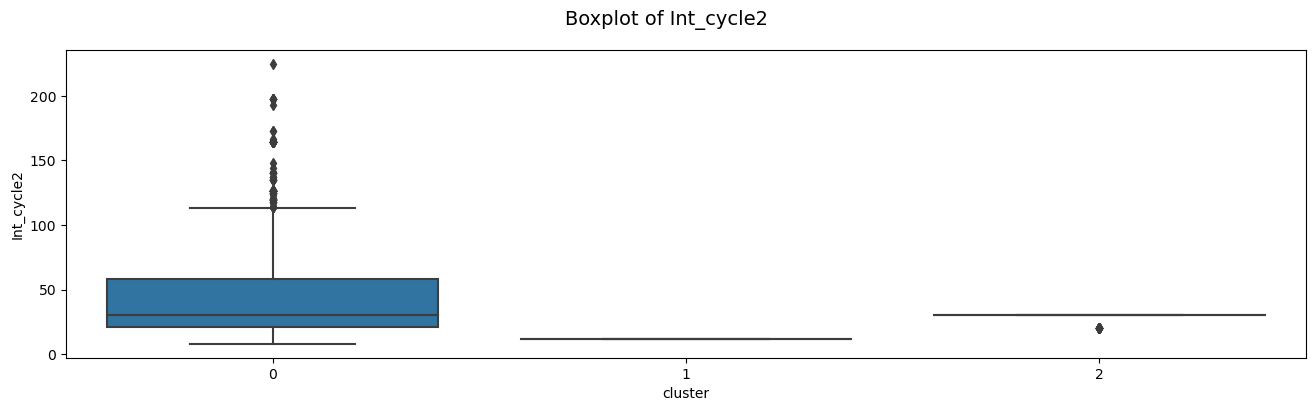

------------------------------------------------------------------------------------





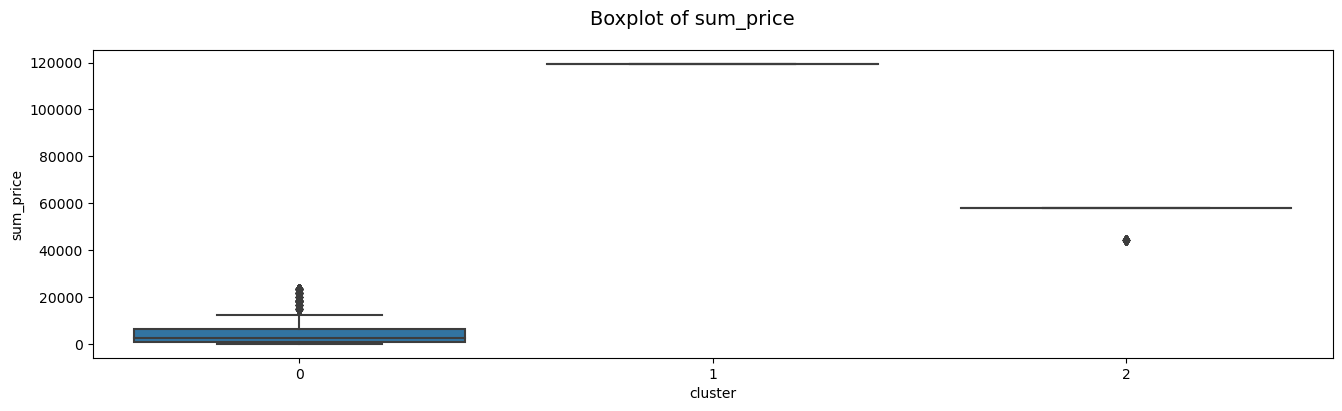

------------------------------------------------------------------------------------





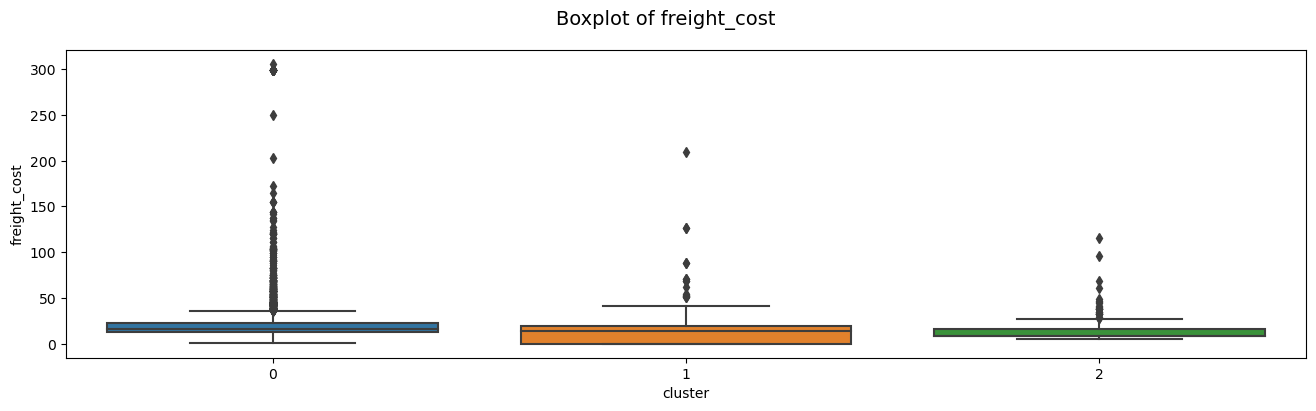

------------------------------------------------------------------------------------





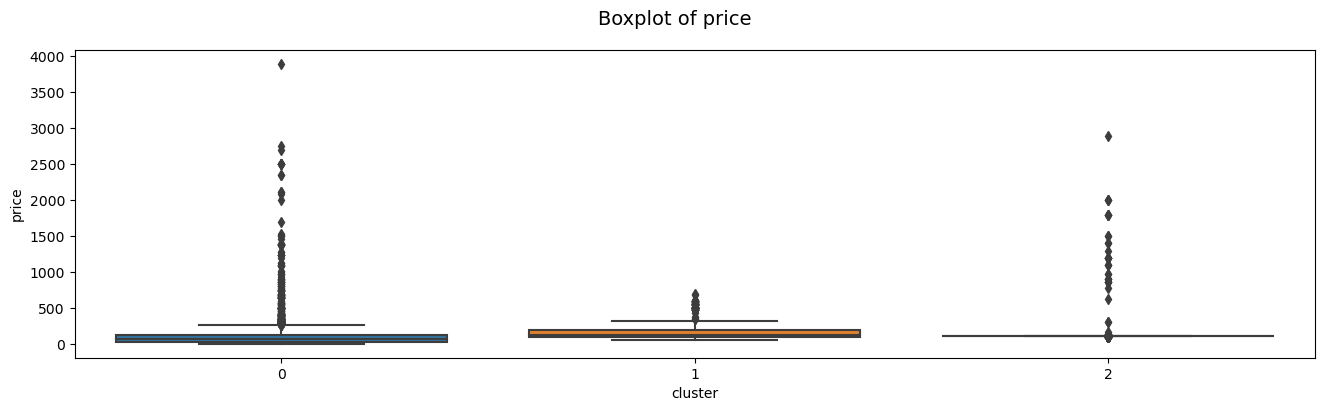

------------------------------------------------------------------------------------





In [305]:
variables = [
    'Int_cycle', 'Int_cycle2', 'sum_price', 'freight_cost', 'price'
]

# Define function to plot distributions of variables
def boxplot(data, y_variable):
    """
    Plot boxplots of variables against Clusters
    """
    fig, ax = plt.subplots(1)
    fig.set_size_inches(16,4)
    fig.suptitle("Boxplot of " + y_variable, fontsize=14)
    sns.boxplot(data=data, y=y_variable, x='cluster')
    plt.show()
    
    print(
          "------------------------------------------------------------------------------------\n\n\n",
          sep = '\n')
    
# Loop through each continuous variable in our data set and run the predefined function
for col in df.columns:
    if col in variables:
        boxplot(data = df, y_variable = col)

In [321]:
sales = pd.merge(sales, df[['merchant_id', 'cluster']], 
                 left_on = 'seller_id', 
                 right_on = 'merchant_id')

sales = sales.drop_duplicates()
sales = sales.reset_index(drop = True)
sales

,seller_id,total_price,business_segment,lead_behavior,business_type,declared_monthly_revenue,avg_review_score_by_seller,origin,avg_freight_cost,Int_cycle,Int_cycle2,merchant_id,cluster
0,7d13fca15225358621be4086e1eb0964,113628.97,watches,Influence / Yellow,reseller,0.0,4.021352,unknown,14.934343,17.0,12.0,7d13fca15225358621be4086e1eb0964,1
1,ba90964cff9b9e0e6f32b23b82465f7b,44212.50,small_appliances,Stability / Green,reseller,0.0,4.421053,organic_search,34.500000,10.0,20.0,ba90964cff9b9e0e6f32b23b82465f7b,2
2,c70c1b0d8ca86052f45a432a38b73958,36537.37,health_beauty,Dominant / Red,reseller,0.0,4.354962,paid_search,11.653580,0.0,30.0,c70c1b0d8ca86052f45a432a38b73958,2
3,612170e34b97004b3ba37eae81836b4c,23065.02,home_appliances,Stability / Green,reseller,0.0,4.429907,organic_search,20.973273,63.0,10.0,612170e34b97004b3ba37eae81836b4c,0
4,6061155addc1e54b4cfb51c1c2a32ad8,15633.40,pet,Stability / Green,reseller,0.0,4.677419,organic_search,26.663939,22.0,42.0,6061155addc1e54b4cfb51c1c2a32ad8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,f1fdf2d13186575751aa25876536d85c,26.30,sports_leisure,Influence / Yellow,reseller,0.0,5.000000,organic_search,8.290000,7.0,13.0,f1fdf2d13186575751aa25876536d85c,0
374,bc8c8d665ec4664d286be0d521722b19,22.50,food_drink,Conformity / Blue,reseller,0.0,2.000000,organic_search,8.320000,101.0,114.0,bc8c8d665ec4664d286be0d521722b19,0
375,455befea1bb853c75ccbca94cff26e5c,19.99,phone_mobile,Stability / Green,reseller,0.0,3.000000,organic_search,22.060000,2.0,59.0,455befea1bb853c75ccbca94cff26e5c,0
376,bb7ad8a45c027be8ab075b8e465f8ca0,19.98,household_utilities,Stability / Green,manufacturer,0.0,5.000000,paid_search,16.320000,75.0,67.0,bb7ad8a45c027be8ab075b8e465f8ca0,0


## Regression for sales

In [322]:
# Make a copy to use sales df for modelling
sales_ML = sales.copy()

### Splitting the data

In [323]:
from sklearn.model_selection import train_test_split

In [341]:
x_var = ['declared_monthly_revenue', 
         'avg_review_score_by_seller', 
         'avg_freight_cost',
         'Int_cycle',
         'Int_cycle2', 
         'cluster']

In [342]:
y_data = sales_ML.loc[ : , 'total_price']
x_data = sales_ML.loc[ : , x_var]

Splitting test and train data

In [343]:
x_train, x_test, y_train, y_test = train_test_split(
            x_data, # x-variables (can change this)
            y_data, # y-variable  (can change this)
            test_size    = 0.25,
            random_state = 1026)

### Creating the models

In [344]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [345]:
# Model initialization
regression_model = LinearRegression()

In [346]:
# Fit the data(train the model)
regression_model.fit(x_train, y_train)

LinearRegression()

In [347]:
# Predict
y_predicted = regression_model.predict(x_test)

In [468]:
# model evaluation
rmse = mean_squared_error(y_test, y_predicted).round(3)
r2 = r2_score(y_test, y_predicted).round(3)

# printing values
print('Slope:' ,regression_model.coef_.round(decimals = 2))
print('Intercept:', regression_model.intercept_.round(decimals = 2))
print('Root mean squared error: ', math.sqrt(rmse))
print('R2 score: ', r2)

Slope: [ 3.175300e+02 -2.210000e+00  1.510000e+00 -2.325000e+01  2.790259e+04
  5.137000e+01 -9.372300e+02  1.414500e+02 -1.935130e+03 -1.429040e+03
  1.815200e+02 -1.265910e+03 -1.464830e+03 -1.824360e+03 -2.235950e+03
 -1.413000e+03 -1.360220e+03 -7.557300e+02 -9.508900e+02 -1.720750e+03
 -1.622960e+03  6.215460e+03 -6.232300e+02  8.398100e+02 -1.728050e+03
 -1.457310e+03 -3.305000e+01 -6.339100e+02 -1.533600e+03 -4.077050e+03
 -1.381570e+03 -1.560300e+03 -2.830160e+03  2.734463e+04  4.990400e+02
 -8.043000e+01 -3.007180e+03  2.226360e+03 -7.557300e+02  1.117940e+03
 -1.110600e+02  1.110600e+02 -0.000000e+00 -4.103700e+02  4.967400e+02
 -6.722900e+02 -3.766500e+02  1.261380e+03 -1.654120e+03  4.551500e+02
  6.131000e+01  8.388500e+02]
Intercept: 1642.93
Root mean squared error:  3088.8452494419334
R2 score:  -1.035


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

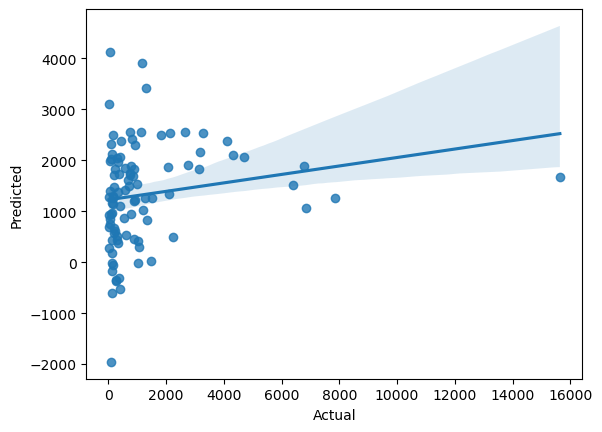

In [349]:
output = pd.DataFrame({'Actual': y_test,
                       'Predicted': y_predicted})
sns.regplot(x="Actual", y="Predicted", data=output)

### One-Hot encoding

In [350]:
from sklearn.preprocessing import OneHotEncoder

In [351]:
# x-variables
x_var = [#'seller_id', 
         'business_segment', 
         'lead_behavior',
         'business_type', 
         'declared_monthly_revenue',
         'avg_review_score_by_seller', 
         'origin', 
         'avg_freight_cost', 
         'Int_cycle',
         'Int_cycle2', 
         #'merchant_id', 
         'cluster']

In [352]:
y_data = sales_ML.loc[ : , 'total_price']
x_data = sales_ML.loc[ : , x_var]

In [353]:
s = (x_data.dtypes == 'object')
object_cols = list(s[s].index)

In [354]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(x_data[object_cols]))

In [355]:
# One-hot encoding removed index; put it back
OH_cols.index = x_data.index

In [356]:
# Ensure we have proper column names
OH_cols.set_axis(np.concatenate(OH_encoder.categories_), axis=1, inplace=True)

In [357]:
# Remove categorical columns (will replace with one-hot encoding)
num_X = x_data.drop(object_cols, axis=1)

In [358]:
# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_cols], axis=1)

In [456]:
x_train, x_test, y_train, y_test = train_test_split(
            OH_X, # x-variables (can change this)
            y_data, # y-variable  (can change this)
            test_size    = 0.25,
            random_state = 1026)

In [457]:
regression_model.fit(x_train, y_train)

y_predicted = regression_model.predict(x_test)

# model evaluation
rmse = math.sqrt(mean_squared_error(y_test, y_predicted).round(3))
r2 = r2_score(y_test, y_predicted).round(3)

# printing values
print('Slope:' ,regression_model.coef_.round(decimals = 2))
print('Intercept:', regression_model.intercept_.round(decimals = 2))
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [ 3.175300e+02 -2.210000e+00  1.510000e+00 -2.325000e+01  2.790259e+04
  5.137000e+01 -9.372300e+02  1.414500e+02 -1.935130e+03 -1.429040e+03
  1.815200e+02 -1.265910e+03 -1.464830e+03 -1.824360e+03 -2.235950e+03
 -1.413000e+03 -1.360220e+03 -7.557300e+02 -9.508900e+02 -1.720750e+03
 -1.622960e+03  6.215460e+03 -6.232300e+02  8.398100e+02 -1.728050e+03
 -1.457310e+03 -3.305000e+01 -6.339100e+02 -1.533600e+03 -4.077050e+03
 -1.381570e+03 -1.560300e+03 -2.830160e+03  2.734463e+04  4.990400e+02
 -8.043000e+01 -3.007180e+03  2.226360e+03 -7.557300e+02  1.117940e+03
 -1.110600e+02  1.110600e+02 -0.000000e+00 -4.103700e+02  4.967400e+02
 -6.722900e+02 -3.766500e+02  1.261380e+03 -1.654120e+03  4.551500e+02
  6.131000e+01  8.388500e+02]
Intercept: 1642.93
Root mean squared error:  3088.8452494419334
R2 score:  -1.035


In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [459]:
x_train, x_test, y_train, y_test = train_test_split(
            OH_X, # x-variables (can change this)
            y_data, # y-variable  (can change this)
            test_size    = 0.25,
            random_state = 1026)

#### Linear Regression

In [460]:
# Fit linear regression model
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
linear_y_pred = linear_reg.predict(x_test)
linear_r2 = r2_score(y_test, linear_y_pred)
linear_rmse = math.sqrt(mean_squared_error(y_test, linear_y_pred).round(3))

#### Exponential Regression

In [461]:
# Fit exponential regression model
exp_reg = LinearRegression()
exp_reg.fit(x_train, np.log(y_train))
exp_y_pred = np.exp(exp_reg.predict(x_test)).round(3)
exp_r2 = r2_score(y_test, exp_y_pred)
exp_rmse = math.sqrt(mean_squared_error(y_test, exp_y_pred).round(3))

#### Polynomial Regression

In [462]:
# Fit polynomial regression model
poly_reg = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly_reg.fit(x_train, y_train)
poly_y_pred = poly_reg.predict(x_test)
poly_r2 = r2_score(y_test, poly_y_pred)
poly_rmse = math.sqrt(mean_squared_error(y_test, poly_y_pred).round(3))

#### Random Forest

In [463]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# train the model on the training data
rf.fit(x_train, y_train)

# make predictions on the test data
rf_y_pred = rf.predict(x_test)

# calculate model performance metrics
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_y_pred))
rf_r2 = r2_score(y_test, rf_y_pred)

### Compare models

In [464]:
# print R-squared scores
print("Linear regression R-squared:", linear_r2)
print("Exponential regression R-squared:", exp_r2)
print("Polynomial regression R-squared:", poly_r2)
print("Random Forest R-squared:", rf_r2)

# print RMSE
print("Linear regression RMSE:", linear_rmse)
print("Exponential regression RMSE:", exp_rmse)
print("Polynomial regression RMSE:", poly_rmse)
print("Random Forest RMSE:", rf_rmse)


Linear regression R-squared: -1.0347913014392236
Exponential regression R-squared: -0.134200415781774
Polynomial regression R-squared: -1329.7726940944224
Random Forest R-squared: -0.4522271379634082
Linear regression RMSE: 3088.8452494419334
Exponential regression RMSE: 2306.1158231970917
Polynomial regression RMSE: 78992.91766171192
Random Forest RMSE: 2609.477092270099


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

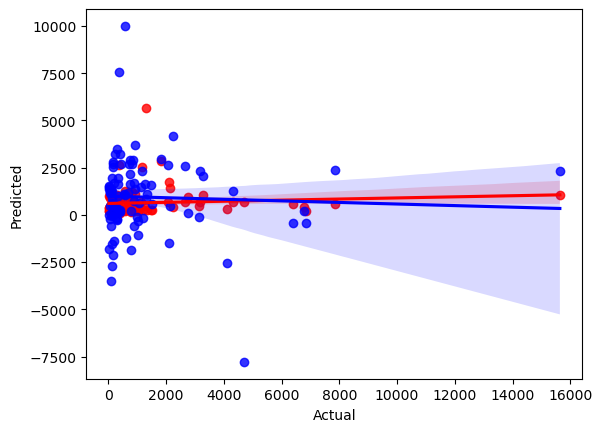

In [465]:
# Plot results
exp_output = pd.DataFrame({'Actual': y_test,
                           'Predicted': exp_y_pred})
sns.regplot(x="Actual", y="Predicted", 
            color = 'red',
            data=exp_output,
            label = 'Exponential')

rf_output = pd.DataFrame({'Actual': y_test,
                          'Predicted': rf_y_pred})
sns.regplot(x="Actual", y="Predicted", 
            color = 'blue',
            data=linear_output,
            label = 'Random Forest')


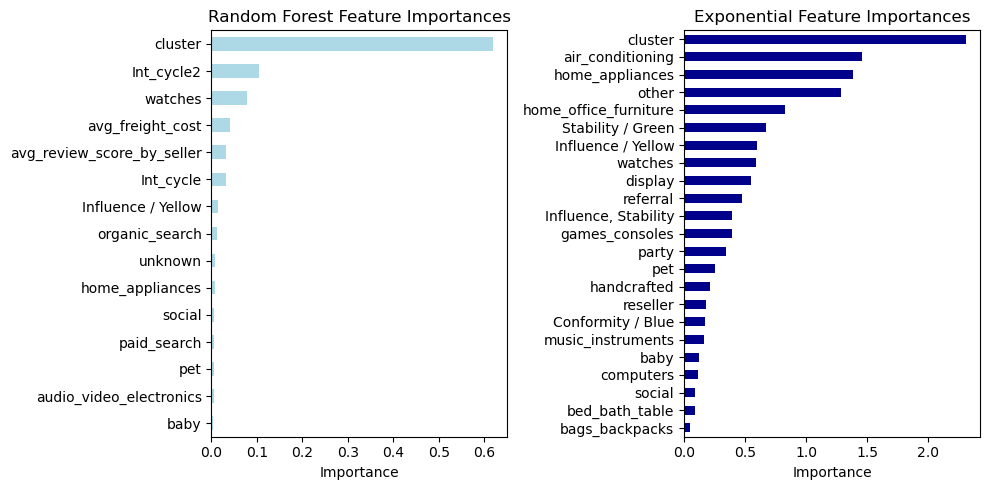

In [471]:
# Get feature importances
rf_importances = pd.Series(data=rf.feature_importances_, index=x_train.columns)
rf_importances = rf_importances[rf_importances > 0.003]
rf_importances_sorted = rf_importances.sort_values()

exp_importances = pd.Series(data=exp_reg.coef_, index=x_train.columns)
exp_importances = exp_importances[exp_importances > 0.05]
exp_importances_sorted = exp_importances.sort_values()

# Plot feature importances
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

rf_importances_sorted.plot(kind='barh', color='lightblue', ax=axes[0])
axes[0].set_title('Random Forest Feature Importances')
axes[0].set_xlabel('Importance')

exp_importances_sorted.plot(kind='barh', color='darkblue', ax=axes[1])
axes[1].set_title('Exponential Feature Importances')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()
